### Importing of libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import sqlite3
%matplotlib inline
import math
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.stats import norm

### Data Import

In [2]:
db_path = r"E:\Machine Learning Research\DataModelling\IDA_Data.db"  # <-- change this to your actual .db file path
table_name = "IDA_Data"                    # <-- your table name

conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

# === Display===
# print(df.shape)
# print(list(df.columns))
# === Optionally, show first few rows ===
# print(InputHeads)
# print(OutputHeads)
# print("\nFirst 5 rows:")
# print(df.columns)
# df.columns

AllColumns = ['id', 'Earthquake', 'ScaleFactor', 'Building', 'BaseCondition', 'ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-', 'Plan-area', 'Seismic-weight', 
              'StiffnessX_Story5', 'StiffnessX_Story4', 'StiffnessX_Story3', 'StiffnessX_Story2', 'StiffnessX_Story1', 'StiffnessX_Total', 'Layer1_FrictionA', 'Layer1_G_kPa', 
              'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion', 'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion',
              'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 'PGA', 'Magnitude', 'Mechanism', 'Rjb', 'Rrup', 'Vs30', 'cav_gs', 
              'scav_gs', 'bcav_gs', 'arias_mps', 'husid_s', 'spi_mps', 'hous_m', 'maxacceleration_mps2', 'maxvelocity_mps', 'maxdisplacement_m', 'maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps', 
              'Fundamental_Period', 'Drift-X_Level-1', 'Drift-X_Level-2', 'Drift-X_Level-3', 'Drift-X_Level-4', 'Drift-X_Level-5', 'Drift-X_Level-6', 'Drift-Y_Level-1', 'Drift-Y_Level-2',
              'Drift-Y_Level-3', 'Drift-Y_Level-4', 'Drift-Y_Level-5', 'Drift-Y_Level-6', 'Displacement-X_Level-1', 'Displacement-X_Level-2', 'Displacement-X_Level-3', 'Displacement-X_Level-4',
              'Displacement-X_Level-5', 'Displacement-X_Level-6', 'Displacement-Y_Level-1', 'Displacement-Y_Level-2', 'Displacement-Y_Level-3', 'Displacement-Y_Level-4', 'Displacement-Y_Level-5',
              'Displacement-Y_Level-6', 'Reaction-Force-X_Level-1', 'Reaction-Force-X_Level-2', 'Reaction-Force-X_Level-3', 'Reaction-Force-X_Level-4', 'Reaction-Force-X_Level-5', 'Reaction-Force-X_Level-6', 
              'Reaction-Force-Y_Level-1', 'Reaction-Force-Y_Level-2', 'Reaction-Force-Y_Level-3', 'Reaction-Force-Y_Level-4', 'Reaction-Force-Y_Level-5', 'Reaction-Force-Y_Level-6', 'Reaction-Moment-X_Level-1',
              'Reaction-Moment-X_Level-2', 'Reaction-Moment-X_Level-3', 'Reaction-Moment-X_Level-4', 'Reaction-Moment-X_Level-5', 'Reaction-Moment-X_Level-6', 'Reaction-Moment-Y_Level-1',
              'Reaction-Moment-Y_Level-2', 'Reaction-Moment-Y_Level-3', 'Reaction-Moment-Y_Level-4', 'Reaction-Moment-Y_Level-5', 'Reaction-Moment-Y_Level-6', 'Rotation-X_Level-1', 'Rotation-X_Level-2',
              'Rotation-X_Level-3', 'Rotation-X_Level-4', 'Rotation-X_Level-5', 'Rotation-X_Level-6', 'Rotation-Y_Level-1', 'Rotation-Y_Level-2', 'Rotation-Y_Level-3', 'Rotation-Y_Level-4', 'Rotation-Y_Level-5',
              'Rotation-Y_Level-6', 'Rotation-Z_Level-1', 'Rotation-Z_Level-2', 'Rotation-Z_Level-3', 'Rotation-Z_Level-4', 'Rotation-Z_Level-5', 'Rotation-Z_Level-6', 'Torsional-Irregularity-Ratio_Level-1',
              'Torsional-Irregularity-Ratio_Level-2', 'Torsional-Irregularity-Ratio_Level-3', 'Torsional-Irregularity-Ratio_Level-4', 'Torsional-Irregularity-Ratio_Level-5', 'Torsional-Irregularity-Ratio_Level-6',
              'Max-Uplift_Level-1', 'Max-Uplift-Point_Level-1', 'Max-Settlement_Level-1', 'Max-Settlement-Point_Level-1', 'Max-Pseudo-Time_Level-1']

In [3]:
### Data Processing

In [4]:
def dataPreparation(DoNormalize = True,Z_ScoreScaler = True    ,        ModelSet = 2     ,includeCategoricalData = False  ):
    
    # Creating of the PeakGroundAcceleration column on the database by product of ScaleFactor and MaximumAcceleration of the data
    df['maxacceleration_mps2'] = pd.to_numeric(df['maxacceleration_mps2'], errors='coerce')
    df['ScaleFactor'] = pd.to_numeric(df['ScaleFactor'], errors='coerce')
    df['PeakGroundAcceleration'] = df['maxacceleration_mps2'] * df['ScaleFactor']
    
    #Creating of the Prediction column as Max drift of the all levels merger in single column as below
    drift_cols = [    'Drift-X_Level-1', 'Drift-X_Level-2', 'Drift-X_Level-3',    'Drift-X_Level-4', 'Drift-X_Level-5', 'Drift-X_Level-6']
    df[drift_cols] = df[drift_cols].apply(pd.to_numeric, errors='coerce')
    df['Max_Drift_X'] = df[drift_cols].max(axis=1)
    
    # Check for any NaNs that might have appeared due to conversion issues
    # print(df[['maxacceleration_mps2', 'ScaleFactor', 'PeakGroundAcceleration']].sample(50))
    # print("Number of NaNs in new column:", df['PeakGroundAcceleration'].isna().sum())
    
    InputHeadsAvailableAll = ['Earthquake', 'ScaleFactor', 'Building', 'BaseCondition', 'ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-', 'Plan-area', 'Seismic-weight', 
                  'StiffnessX_Story5', 'StiffnessX_Story4', 'StiffnessX_Story3', 'StiffnessX_Story2', 'StiffnessX_Story1', 'StiffnessX_Total', 
                  'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
                  'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
                  'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
                  'PGA', 'Magnitude', 'Mechanism', 'Rjb', 'Rrup', 'Vs30', 'cav_gs', 'scav_gs', 'bcav_gs', 'arias_mps', 'husid_s', 'spi_mps', 'hous_m', 'maxacceleration_mps2',
                  'maxvelocity_mps', 'maxdisplacement_m', 'maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps', 
                  'Fundamental_Period']
    InputHeadsSelected = ['ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-', 'Building', 'BaseCondition',
                   
                  'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
                  'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
                  'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
                          
                  "PeakGroundAcceleration", 'Magnitude', 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',  'cav_gs', 
                             'Fundamental_Period']
    
    #Best performer for the fixedbase and displacement output
                   # "PeakGroundAcceleration", 'Magnitude', 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',  'cav_gs', 
                   #           'Fundamental_Period']
    #Best performer for the maximum drift along X with r2 as 89.36 (Donot include  'Plan-area', 'Seismic-weight', 'StiffnessX_Total', as they donot produce any effect and only add burden to model)
    # InputHeadsSelected = ['ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-',
                   
    #               'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
    #               'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
    #               'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
                          
    #               "PeakGroundAcceleration", 'Magnitude', 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',  'cav_gs', 
    #                          'Fundamental_Period']
    #Best performer for the fixed and output as Reaction-Force-X_Level-1:  r2 as 0.95 max with 15 features
    # InputHeadsSelected = ['Earthquake', 'Building', 'Fundamental_Period',  'ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx',
    #               'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
    #               'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
    #               'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
    #                "PeakGroundAcceleration", 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',
    #                         ]
    #For soil analysis take Rup, Vs30... Use maxacceleration_mps2 that represents the pga value of site and for the building specific analysis ie performance
    # Levels measurement take PSA, PSV and PSD values over the peac acc peak vel and peak disp and so on 
    #Final selected features (9): ['ScaleFactor', 'Vs30', 'cav_gs', 'arias_mps', 'husid_s', 'hous_m', 'maxvelocity_mps', 'maxdisplacement_m', 'maxpsd_cmps']
    
    
    
    #_______________________________________________________________________________________________________________________________________________________________Processing starts from here
    if ModelSet == 1 or ModelSet == 3:
        InputHeads = [x for x in InputHeadsSelected if not x.startswith("Layer")] 
    else:
        InputHeads = InputHeadsSelected
    # OutputHeads = ['Displacement-X_Level-5']
    # OutputHeads = ["Reaction-Force-X_Level-1"]
    OutputHeads = ['Max_Drift_X']
    
    # df[InputHeads].info
    
    ####__________________________________________________________________________________________________________________________________Data selection 
    
    # Extract all the data from the fixed base conditions only
    if ModelSet == 1:
        df_fixed = df[df['BaseCondition'] == 'Fixed']
    elif ModelSet == 2:
        df_fixed = df[df['BaseCondition'] != 'Fixed']
    else:
        df_fixed = df[df['BaseCondition'].isin(['Fixed', 'Soft', 'Medium', 'Hard'])]
        
    
    #Convert all the data in database to numerical format
    df_numeric = df_fixed.copy()
    for col in df_numeric.columns:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='ignore')
    # if includeCategoricalData:
    #     df_numeric = df_fixed.copy()
    #     for col in df_numeric.columns:
    #         df_numeric[col] = pd.to_numeric(df_numeric[col], errors='ignore')
    # else:
    #     df_numeric = df_fixed.apply(pd.to_numeric, errors='coerce')
    #     df_numeric.shape
    
    ##Extract the data if the scale factor is less than or equal to 1 only
    if ModelSet != 1:
        df_numeric = df_numeric[df_numeric['ScaleFactor'] <= 1]
    # df_numeric = df_numeric[df_numeric['ScaleFactor'] <= 1]

    ####__________________________________________________________________________________________________________________________________Encoding of data
    # # Normalize for the data of the features as seismic weights, and so on
    # features_to_normalize = [x for x in InputHeads
    #                          if pd.api.types.is_numeric_dtype(df_numeric[x])]
    
    
    #One hot encoding of the categorical data if user set it to include in the model
    # if includeCategoricalData:
    #     print(len(features_to_normalize))
    #     print(len(InputHeads))
    #     print([x for x in InputHeads if x not in features_to_normalize])
    #     Catcolumns =  [x for x in InputHeads if x not in features_to_normalize]
    #     if Catcolumns:
    #         data_toEncode = df_numeric[Catcolumns]
        
    #         CatDataEncoded = pd.get_dummies(data_toEncode, columns = Catcolumns,  dtype=float)
    #         df_numeric = df_numeric.drop(columns=Catcolumns)
        
    #         if df_numeric.shape[0] == CatDataEncoded.shape[0]:
    #             df_numeric = pd.concat([df_numeric, CatDataEncoded], axis=1)
    #         else: 
    #             raise
    
    #Removing all the white spaces on the column titles
    df_numeric.columns = df_numeric.columns.str.replace(" ", "_")
    
    ## Converts all the data to the numeric even to that of hot encoded as they are in float
    # df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
    
    
    # ####__________________________________________________________________________________________________________________________________Missing Data Handling
    # df_numeric =df_numeric.dropna(axis=1, how='all')             #Dropping for all the columns (axis = 1) if it has all values of NaN
    
    # #### Show only columns that actually contain NaN
    # # nan_counts = df_numeric.isna().sum()
    # # nan_counts = nan_counts[nan_counts > 0]
    # # print("Columns containing NaN values (column: count):")
    # # print(nan_counts)
    
    # # nan_rows = df_numeric[df_numeric.isna().any(axis=1)]
    # # print("Rows containing NaN values:")
    # # print(nan_rows)
    
    df_numeric = df_numeric.apply(lambda col: col.fillna(col.median()) if col.dtype != 'object' else col)   #For any value other than object if the data is shown as missing then it fills up with the median of that column
    
    # # nan_counts = df_numeric.isna().sum()
    # # nan_counts = nan_counts[nan_counts > 0]
    # # print("Columns containing NaN values (column: count):")
    # # print(nan_counts)
    
    # df_numeric = df_numeric.dropna()                             #Now also if any of the Nan data persists then the system drops that specific rows
    
    
    ####__________________________________________________________________________________________________________________________________Normalization of data
    # if DoNormalize:
    #     scaler = MinMaxScaler(feature_range=(0, 1))
    #     if Z_ScoreScaler:
    #         scaler = StandardScaler()
    #     cols_to_scale = [c for c in features_to_normalize if c in df_numeric.columns] # Only normalize columns that actually exist in df
    #     df_numeric[cols_to_scale] = scaler.fit_transform(df_numeric[cols_to_scale])
    
    ####__________________________________________________________________________________________________________________________________Assignment of the training data
    
    # # Extract for the data to be in x and y variables
    X = df_numeric[[col for col in InputHeads if col in df_numeric.columns]]
    y = df_numeric[[col for col in OutputHeads if col in df_numeric.columns]]
    
    # df_numeric = pd.concat([X, y], axis=1)  # combine X and y
    
    # X.shape
    # print((X.columns))
    # cols = CatDataEncoded.columns
    # for co in cols:
    #     print(co)
    # print(CatDataEncoded.columns)
    # df_numeric.sample(10)
    # X.shape

    return X, y, df_numeric



# Calling Zone

In [39]:


# Data initiation 
# =============================================================================================================================================================================================

#Data fixation for the model
DoNormalize = False
Z_ScoreScaler = True                       #If false then MinMax Scaler is used in the modelling
ModelSet = 3                        #1 denotes fixed base (SF all upto 4), 2 denotes SSI only case (SF upto 1 and inputheads include Layers) 3 denotes total datasets, (SF upto 1 , excluding soil layers ie Fixed similar)
includeCategoricalData = False               #True sets the categorical datta intact and False triggers the one hot encoding to the categorical data
X, y, df_numeric = dataPreparation(DoNormalize = DoNormalize,Z_ScoreScaler = Z_ScoreScaler, ModelSet = ModelSet ,includeCategoricalData = includeCategoricalData  )

#Selecting data for the IDA fragility plots
list1 = ["Max_Drift_X", 'ScaleFactor', 'Displacement-X_Level-5']

Buildings = df['Building'].unique()
Earthquakes = df['Earthquake'].unique()[:5]
Earthquakes = [x.split("_") for x in Earthquakes]
Earthquakes = ["".join(x[0:-2]) for x in Earthquakes]


# # Earthquakes = [" ".join(part[0:-1] for part in x.spit("_")) for x in Earthquakes]
# print(Buildings, Earthquakes)
# # reqDB = df[]
# print(list(df.columns))
# # list1 = ["Max_Drift_X", 'Rotation-Z_Level-5', 'Displacement-X_Level-5']
# # print(df[list1])
df_numeric.shape

C:\Users\Acer\AppData\Local\Temp\ipykernel_17328\196481435.py:84: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_numeric[col] = pd.to_numeric(df_numeric[col], errors='ignore')


(3447, 136)

# Excel-style smoothing (Catmull–Rom spline)
## Creation of IDA curves with correction where Sa(T1) as Y and IDR as X axis

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np

# --------------------------------------------------
# Excel-style smoothing (Catmull–Rom spline)
# --------------------------------------------------
def excel_smooth(x, y, points=200, tension=0.0, sortby=None):
    """
    Excel-like smoothing sorted by Y (or sortby) instead of X.
    """
    x = np.array(x)
    y = np.array(y)
    
    if sortby is None:
        sortby = y
    idx = np.argsort(sortby)
    x, y = x[idx], y[idx]

    if len(x) < 3:
        return x, y

    xs, ys = [], []

    for i in range(len(x)-1):
        x0 = x[i-1] if i-1 >= 0 else x[i]
        y0 = y[i-1] if i-1 >= 0 else y[i]

        x1, y1 = x[i], y[i]
        x2, y2 = x[i+1], y[i+1]

        x3 = x[i+2] if i+2 < len(x) else x[i+1]
        y3 = y[i+2] if i+2 < len(y) else y[i+1]

        t = np.linspace(0, 1, points)
        t2 = t * t
        t3 = t2 * t

        s = (1 - tension) / 2  # 0 = Catmull-Rom

        xt = (-s*x0 + (2-s)*x1 + (s-2)*x2 + s*x3)*t3 + \
             (2*s*x0 + (s-3)*x1 + (3-2*s)*x2 - s*x3)*t2 + \
             (-s*x0 + s*x2)*t + x1

        yt = (-s*y0 + (2-s)*y1 + (s-2)*y2 + s*y3)*t3 + \
             (2*s*y0 + (s-3)*y1 + (3-2*s)*y2 - s*y3)*t2 + \
             (-s*y0 + s*y2)*t + y1

        xs.extend(xt)
        ys.extend(yt)

    return np.array(xs), np.array(ys)


# --------------------------------------------------
# Stretch series when x decreases
# --------------------------------------------------
def enforce_and_stretch_FromFirstXdecrementtoGlobalMax(x, y, x_max):
    """
    Walk through series; if x decreases while y increases, stretch
    from last valid point to x_max with constant y.
    Ensures last point is always at x_max.
    """
    x = np.array(x)
    y = np.array(y)
    
    # Check for first decrease and stretch from that point
    for i in range(1, len(x)):
        if x[i] < x[i-1]:
            xs = np.concatenate([x[:i], [x_max]])
            ys = np.concatenate([y[:i], [y[i-1]]])
            return xs, ys
    
    # If no decrease, just ensure last point reaches x_max
    if x[-1] < x_max:
        x = np.append(x, x_max)
        y = np.append(y, y[-1])
    
    return x, y

def enforce_and_stretch_FromSeriesMaxtoGlobalMax(x, y, x_max_building):
    """
    Stretch a series to ensure:
    1. It reaches its individual maximum x naturally.
    2. After that, it is stretched horizontally to the global maximum of the plot
       keeping the last y constant.
    """
    x = np.array(x)
    y = np.array(y)

    # Step 1: find index of the maximum x in the series
    max_idx = np.argmax(x)

    # Step 2: keep the series up to its max x
    x_part = x[:max_idx+1]
    y_part = y[:max_idx+1]

    # Step 3: if the series max x < global max, append a horizontal stretch
    if x_part[-1] < x_max_building:
        x_part = np.append(x_part, x_max_building)
        y_part = np.append(y_part, y_part[-1])

    return x_part, y_part

# --------------------------------------------------
# PLOTTING FUNCTION
# --------------------------------------------------
def CreatePlots(df_numeric, X_Column, Y_Column, sortby, smooth=True, averageplt = True , colourPlot = True):
    Buildings = df_numeric["Building"].unique()
    Earthquakes = df_numeric["Earthquake"].unique()#[:5]

    colors = [
        "#FF00FF", "#00FFFF", "#7FFF00", "#39FF14", "#9B30FF",
        "#FF073A", "#1F51FF", "#FF69B4", "#FFFF00", "#FC6C85",
        "#32CD32", "#000000", "#333333", "#00CED1", "#00BFFF",
        "#FFBF00", "#FFAA00", "#77DD77", "#66CDAA", "#E6E6FA",
        "#9370DB", "#4B0082"
    ]

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["axes.linewidth"] = 1.4

    legend_handles = []
    legend_labels = []

    x_max_global = df_numeric[X_Column].max()  # max IDR across dataset

    for building in Buildings:
        fig, ax = plt.subplots(figsize=(8, 8))

        # Collect all series for averaging
        all_x_series = []
        all_y_series = []

        for i, earthquake in enumerate(Earthquakes):
            subset = df_numeric[(df_numeric["Building"] == building) &
                                (df_numeric["Earthquake"] == earthquake)]
            if subset.empty:
                continue

            subset_sorted = subset.sort_values(by=sortby, ascending=True)
            x_orig = subset_sorted[X_Column].values
            y_orig = subset_sorted[Y_Column].values
            
            x_max_series = x_orig.max()  # maximum x value of the current series
            
            # Stretch series if x decreases
            # x_stretch, y_stretch = enforce_and_stretch_FromSeriesMaxtoGlobalMax(x_orig, y_orig, x_max_global)
            x_stretch, y_stretch = enforce_and_stretch_FromFirstXdecrementtoGlobalMax(x_orig, y_orig, x_max_global)

            # Optional smoothing
            if smooth:
                x_plot, y_plot = excel_smooth(x_stretch, y_stretch, points=60, tension=0.0, sortby=y_stretch)
            else:
                x_plot, y_plot = x_stretch, y_stretch

            # Plot series in light grey
            colour = "#D3D3D3"
            if colourPlot :
                colour = colors[i % len(colors)]
            ax.plot(x_plot, y_plot, color=colour, lw=1.8, alpha=0.8) #colors[i % len(colors)]


            # Collect for average curve
            all_x_series.append(x_plot)
            all_y_series.append(y_plot)

            # Collect legend only once (first building)
            if building == Buildings[0]:
                line, = ax.plot([], [], color=colour, lw=1.8, alpha=0.8)  # dummy for legend  #colors[i % len(colors)]
                legend_handles.append(line)

                earthquake = earthquake.split("_")
                earthquake = "".join(earthquake[0:-2])
                legend_labels.append(earthquake)

        # Compute average curve
        if averageplt:
            if all_x_series:
                # Interpolate all series on common x-axis
                common_x = np.linspace(0, x_max_global, 300)
                y_interp = np.zeros((len(all_y_series), len(common_x)))
    
                for j, (x_s, y_s) in enumerate(zip(all_x_series, all_y_series)):
                    y_interp[j, :] = np.interp(common_x, x_s, y_s)
    
                y_mean = np.mean(y_interp, axis=0)
                # Plot average curve in red
                ax.plot(common_x, y_mean, color="red", lw=2.0, alpha=0.9, label="Average")

        # Annotation
        trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
        ax.text(
            0.70, 0.90,
            f"Building model: {building}",
            transform=trans,
            fontsize=13,
            ha="left",
            va="top",
            bbox=dict(boxstyle="round,pad=0.40", edgecolor="black",
                      facecolor="white", linewidth=1.2, alpha=0.95)
        )

        ax.set_xlabel("IDR", fontsize=16)
        ax.set_ylabel("Sa(T1)g", fontsize=16)
        ax.grid(True, linestyle="--", alpha=0.4)

        plt.tight_layout()
        filename = f"plot_building_{building}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()

    # Create separate legend figure
    fig_legend = plt.figure(figsize=(6, 2))
    ax_leg = fig_legend.add_subplot(111)
    ax_leg.axis("off")
    ax_leg.legend(handles=legend_handles, labels=legend_labels, loc='center', ncol=3, frameon=False , title="Earthquakes", fontsize=10)
    plt.tight_layout()
    plt.savefig("legend_only.png", dpi=300, bbox_inches="tight")
    plt.show()



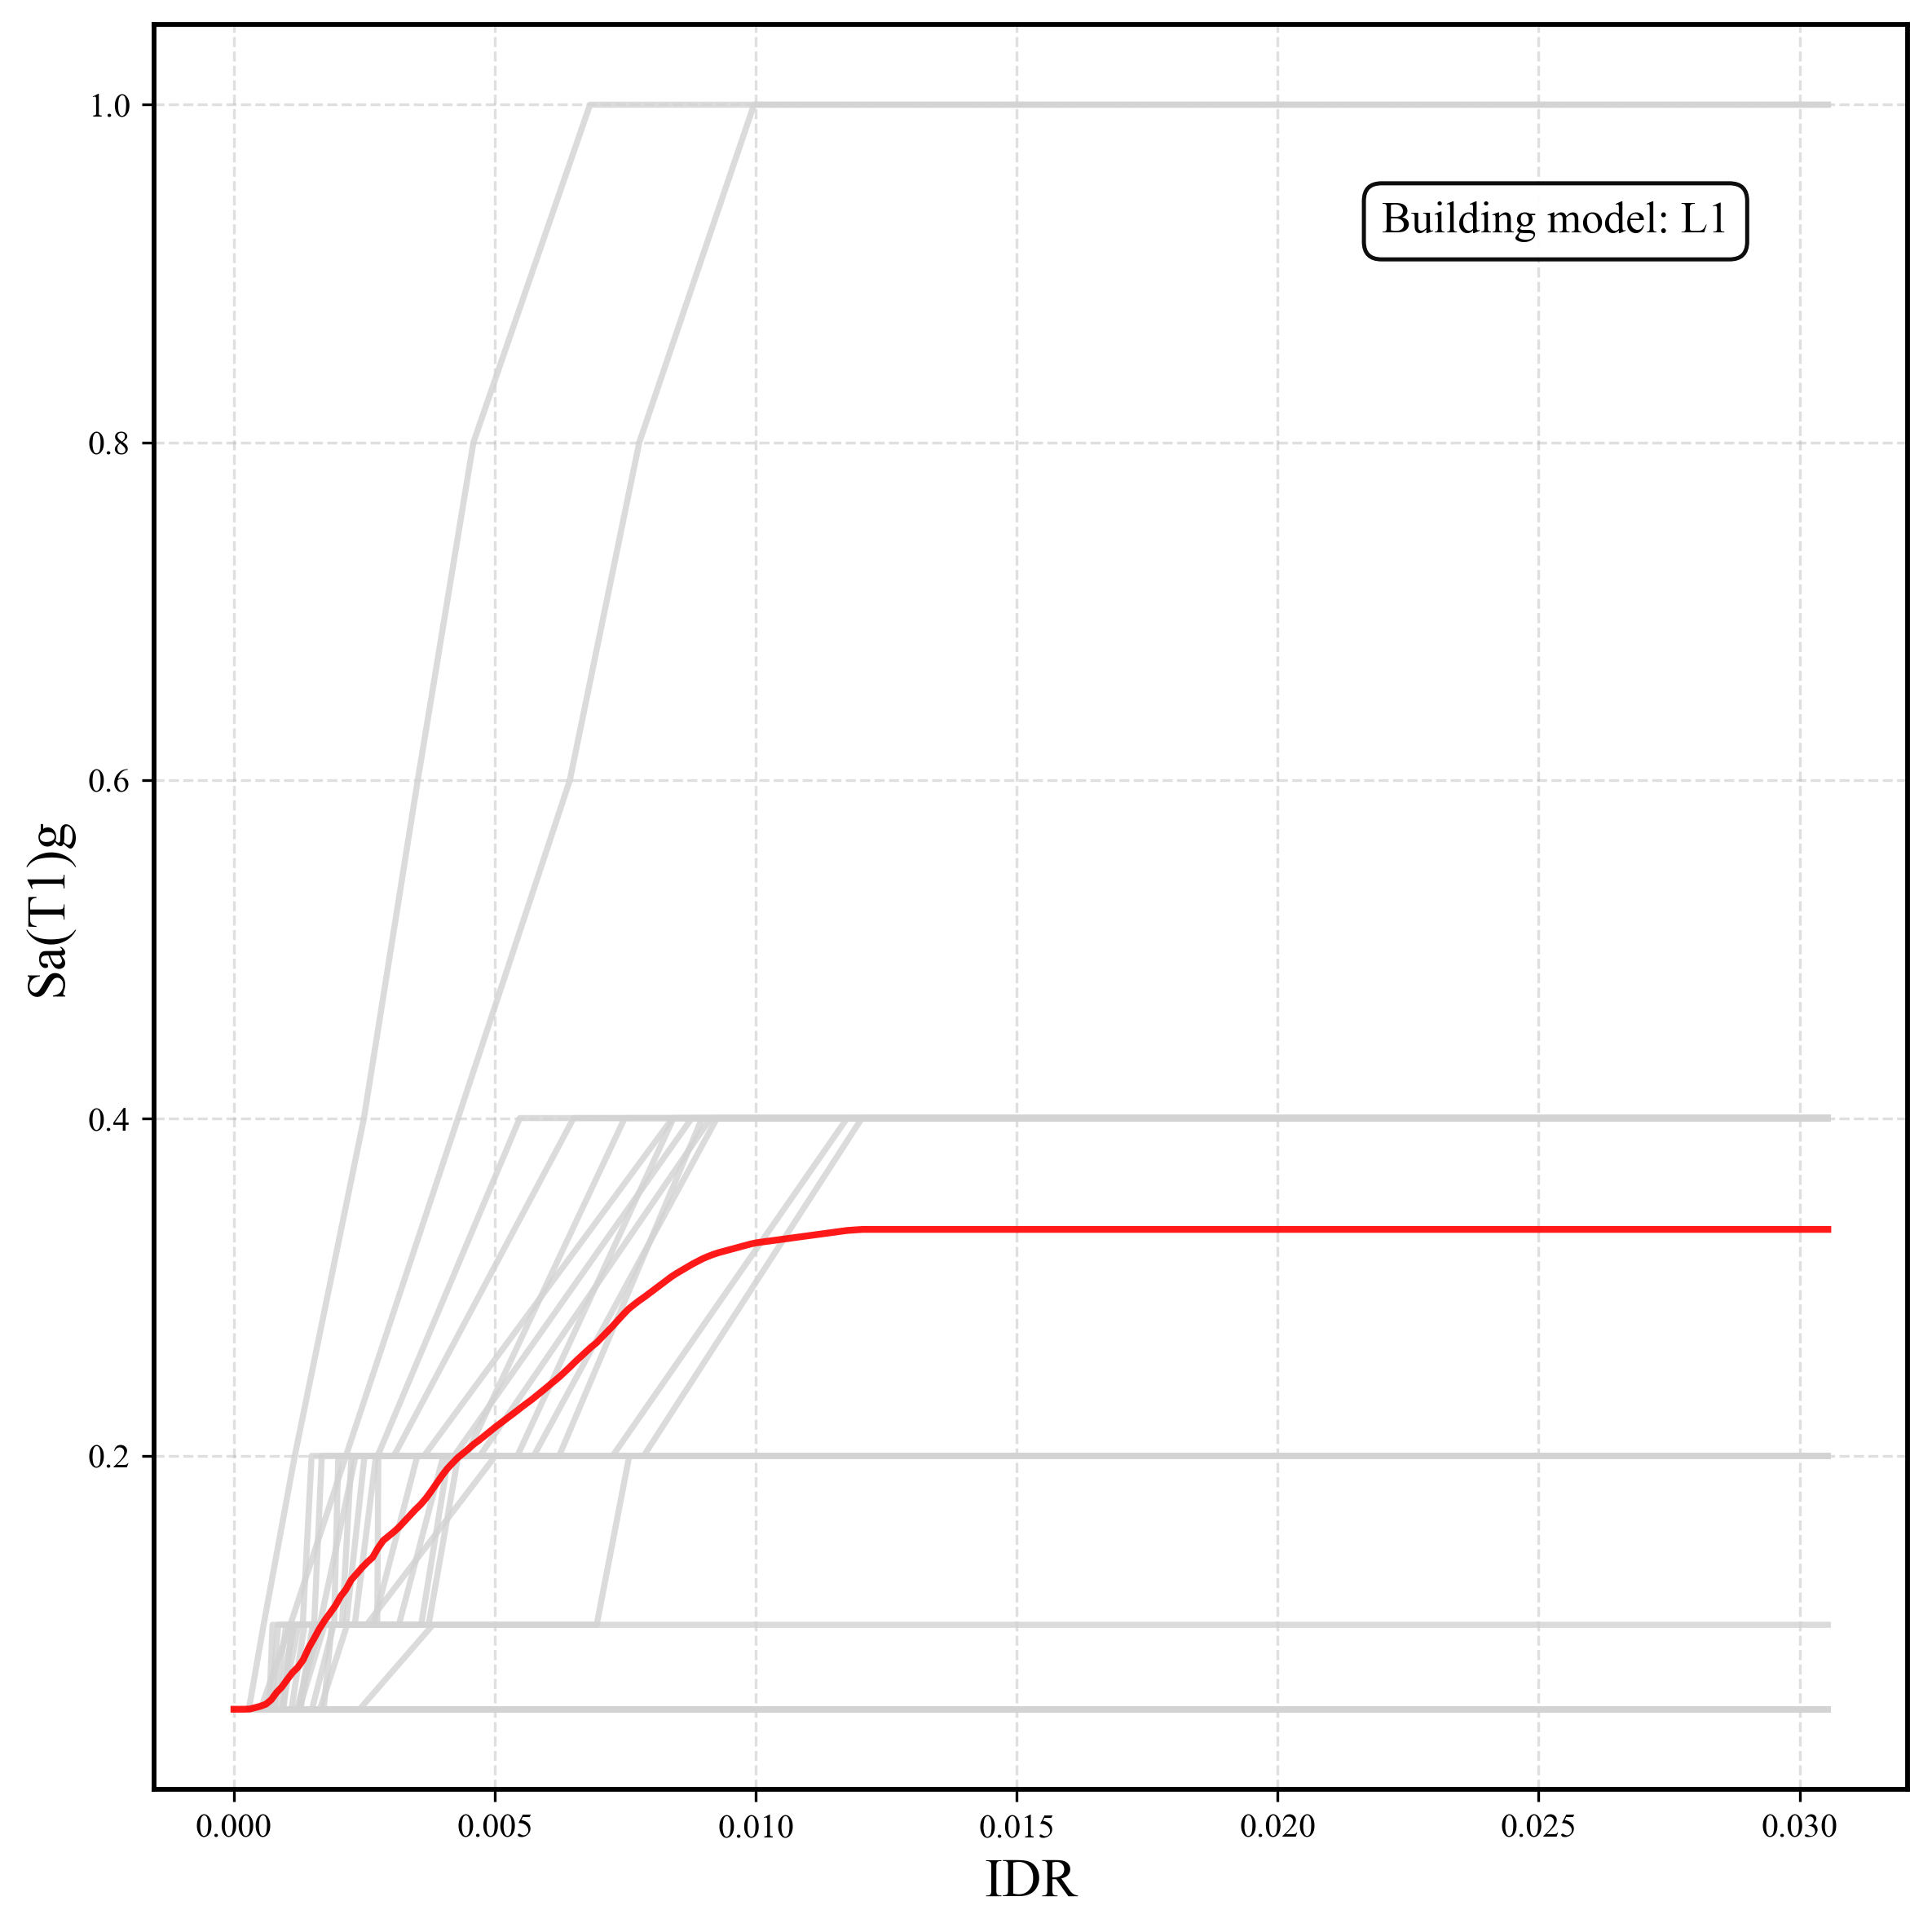

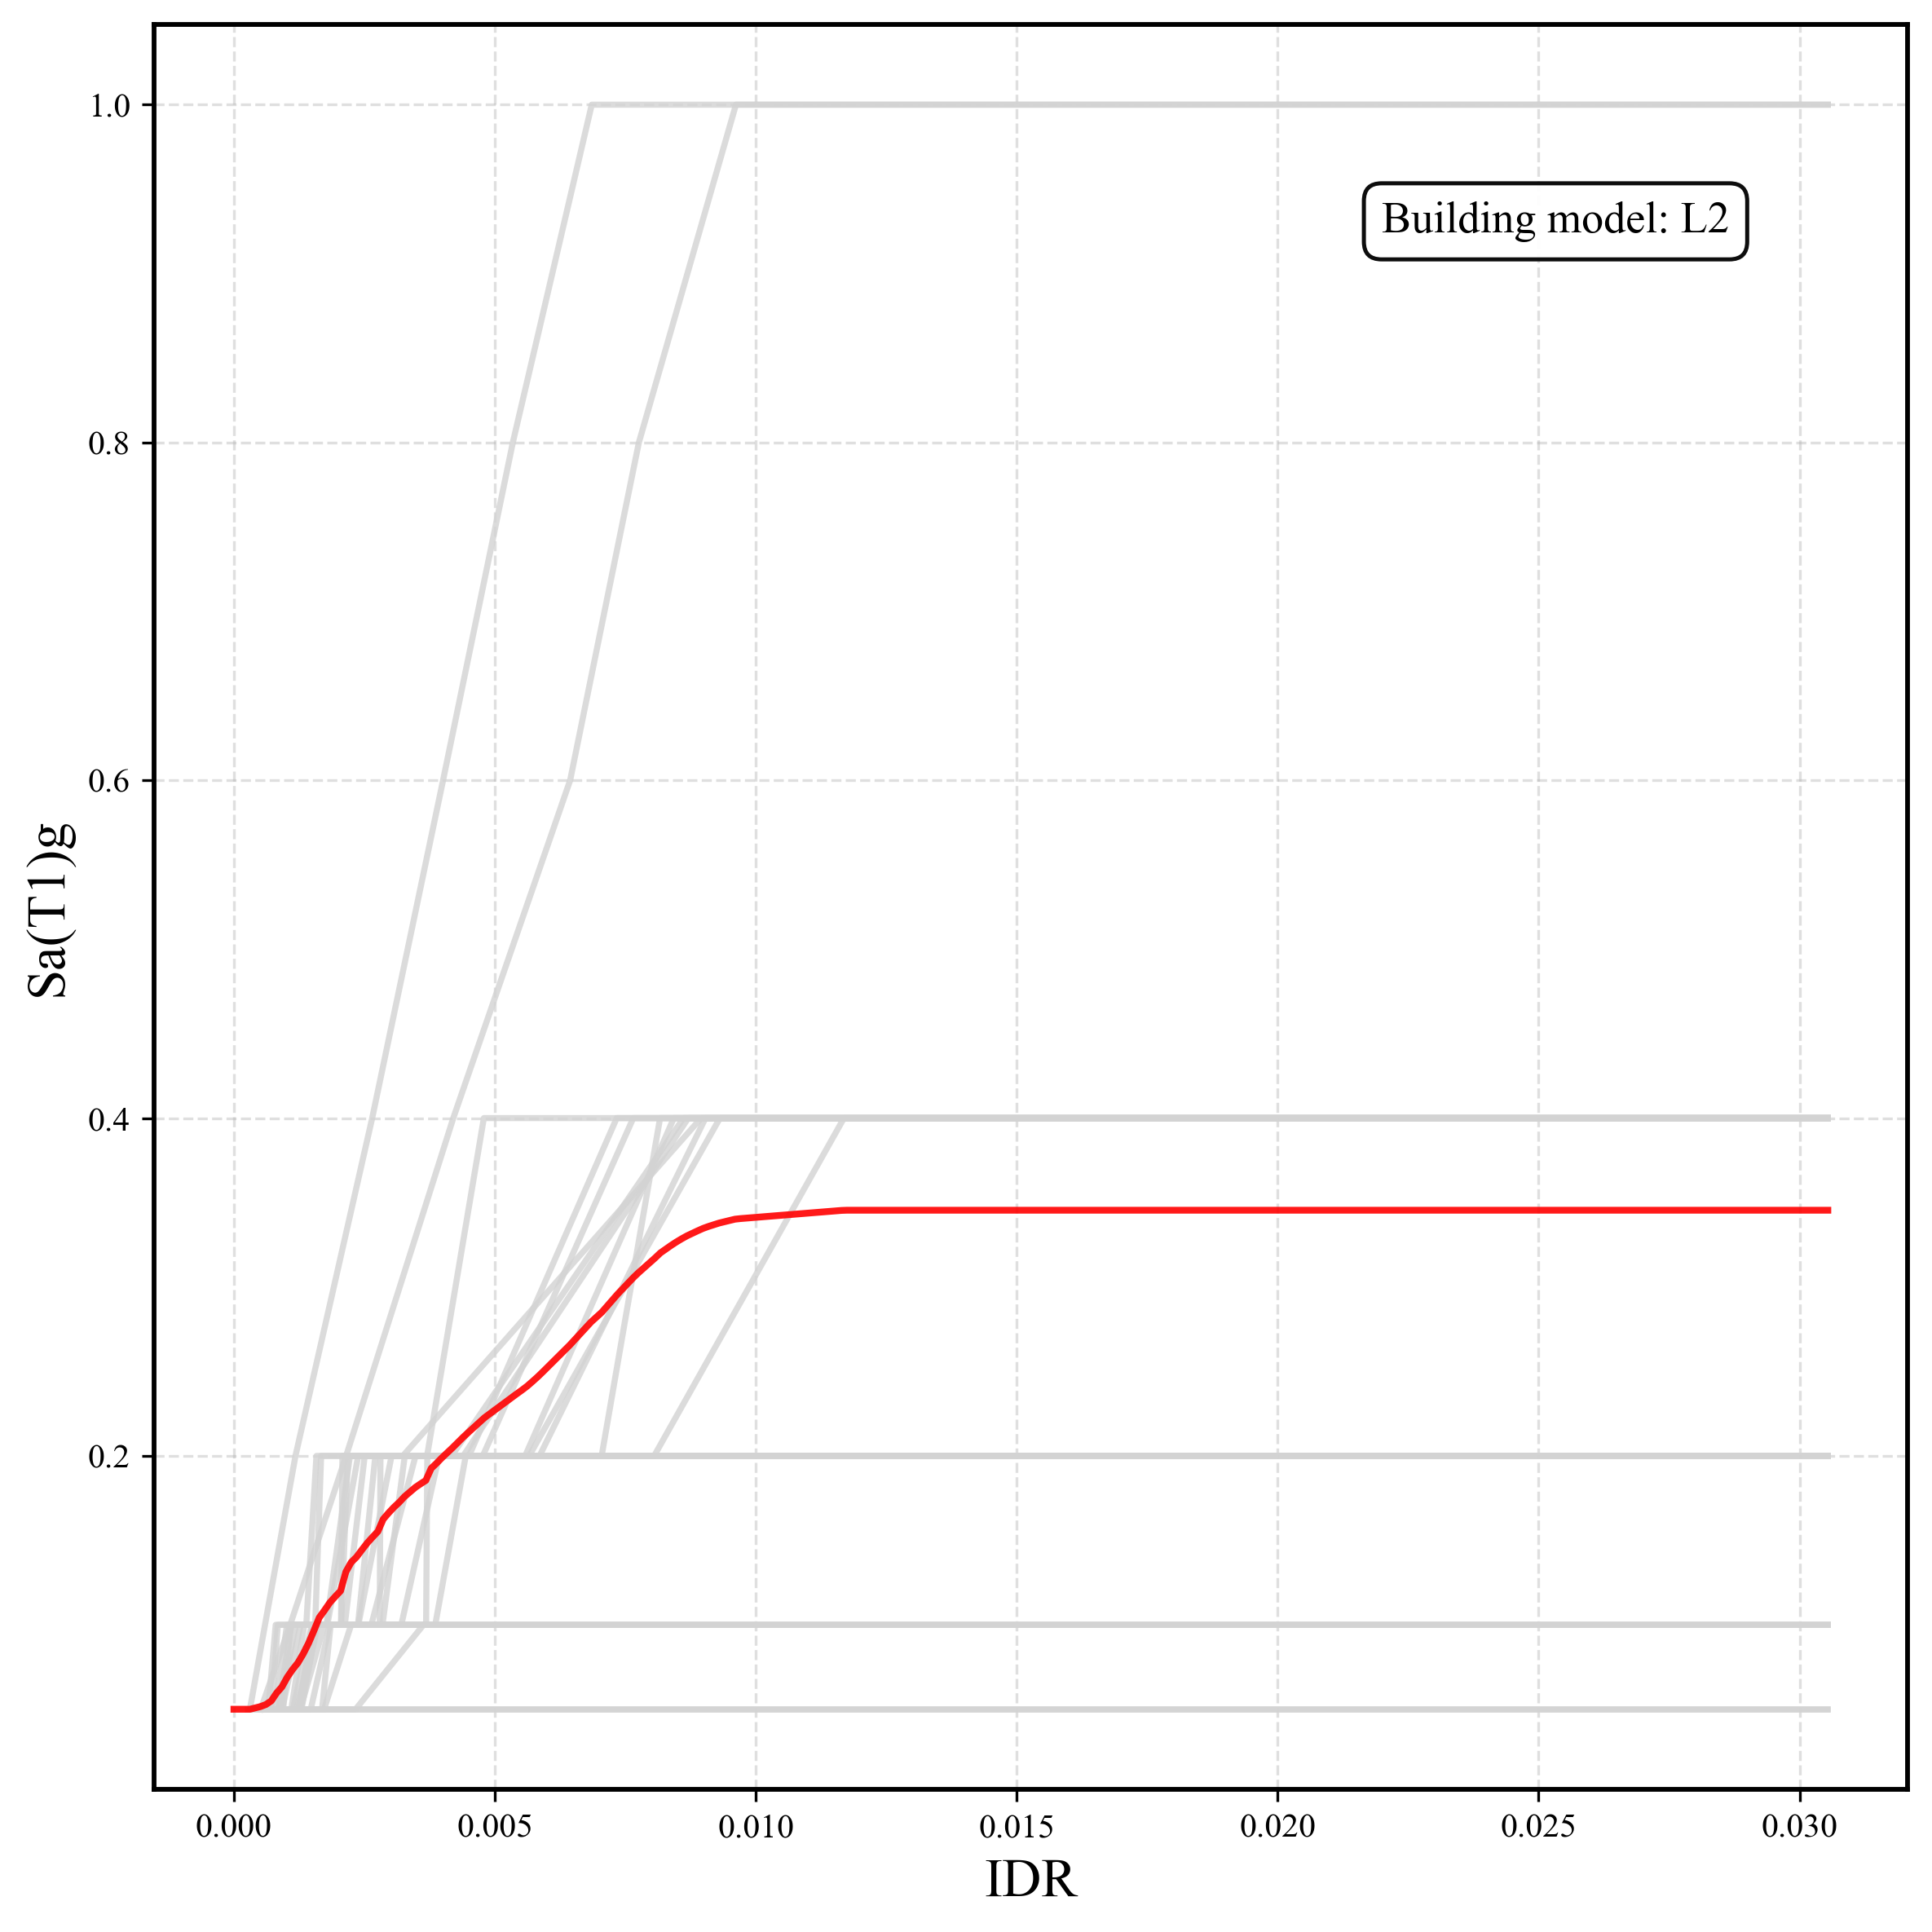

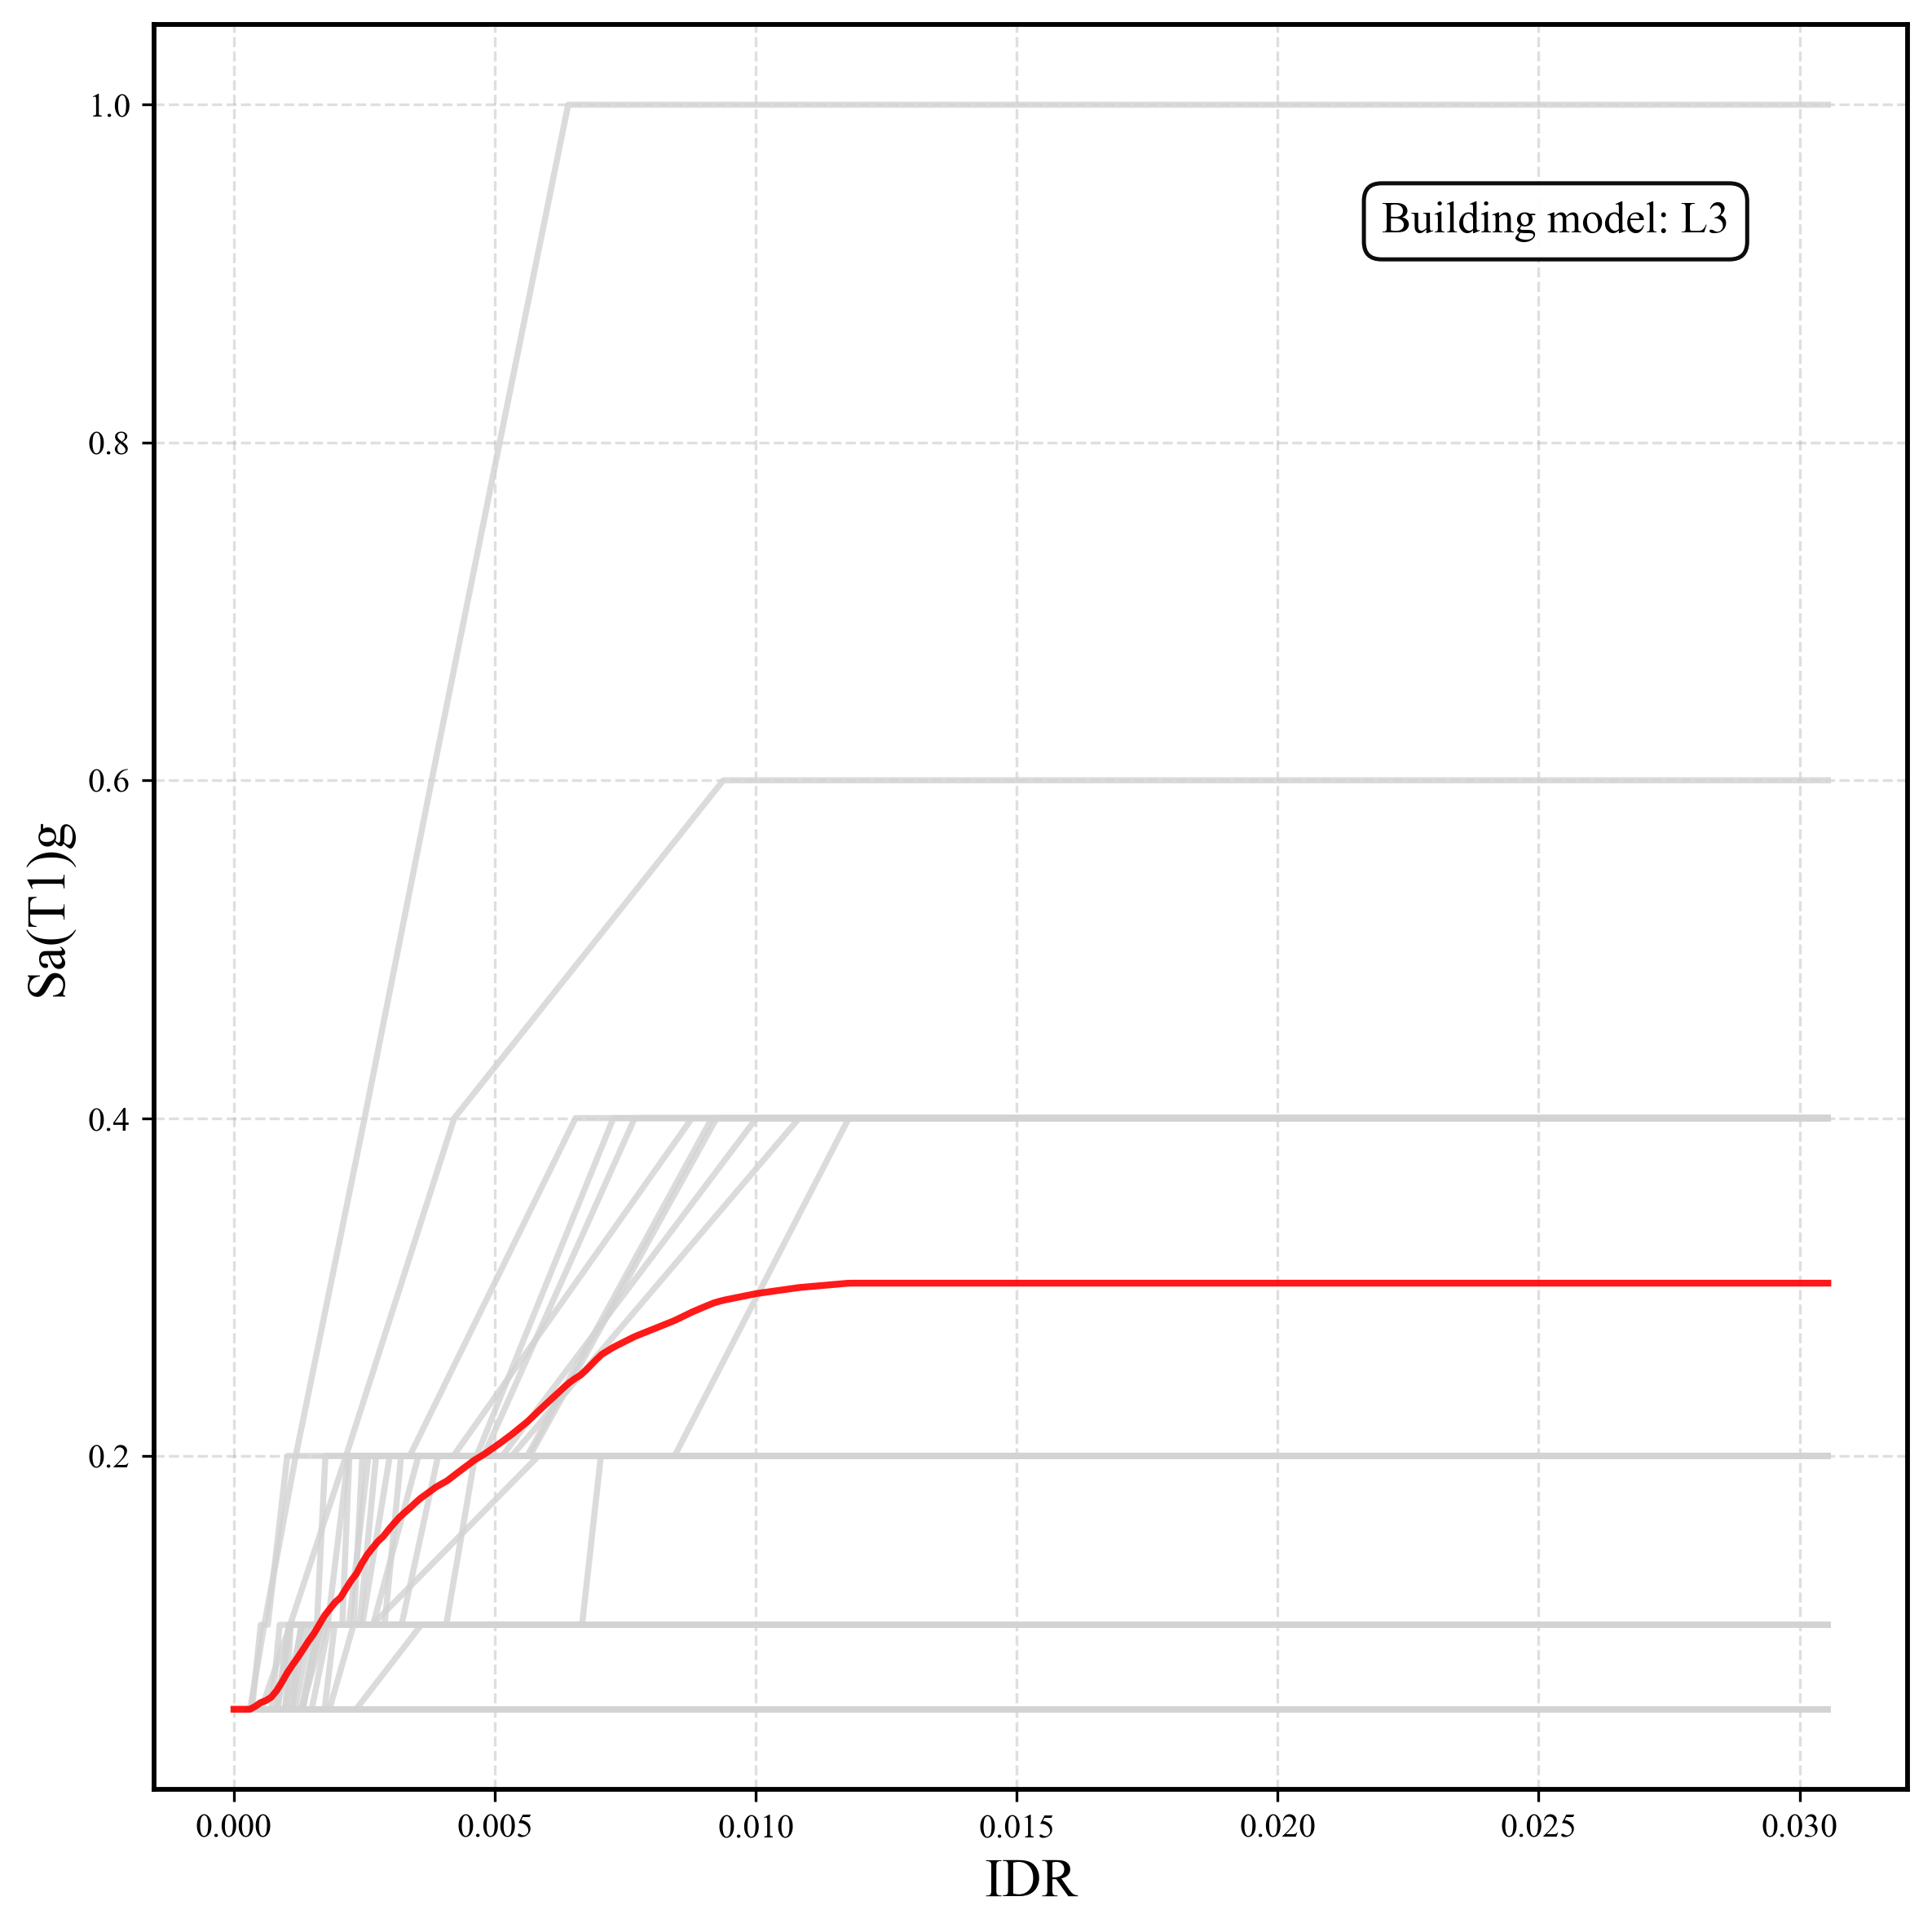

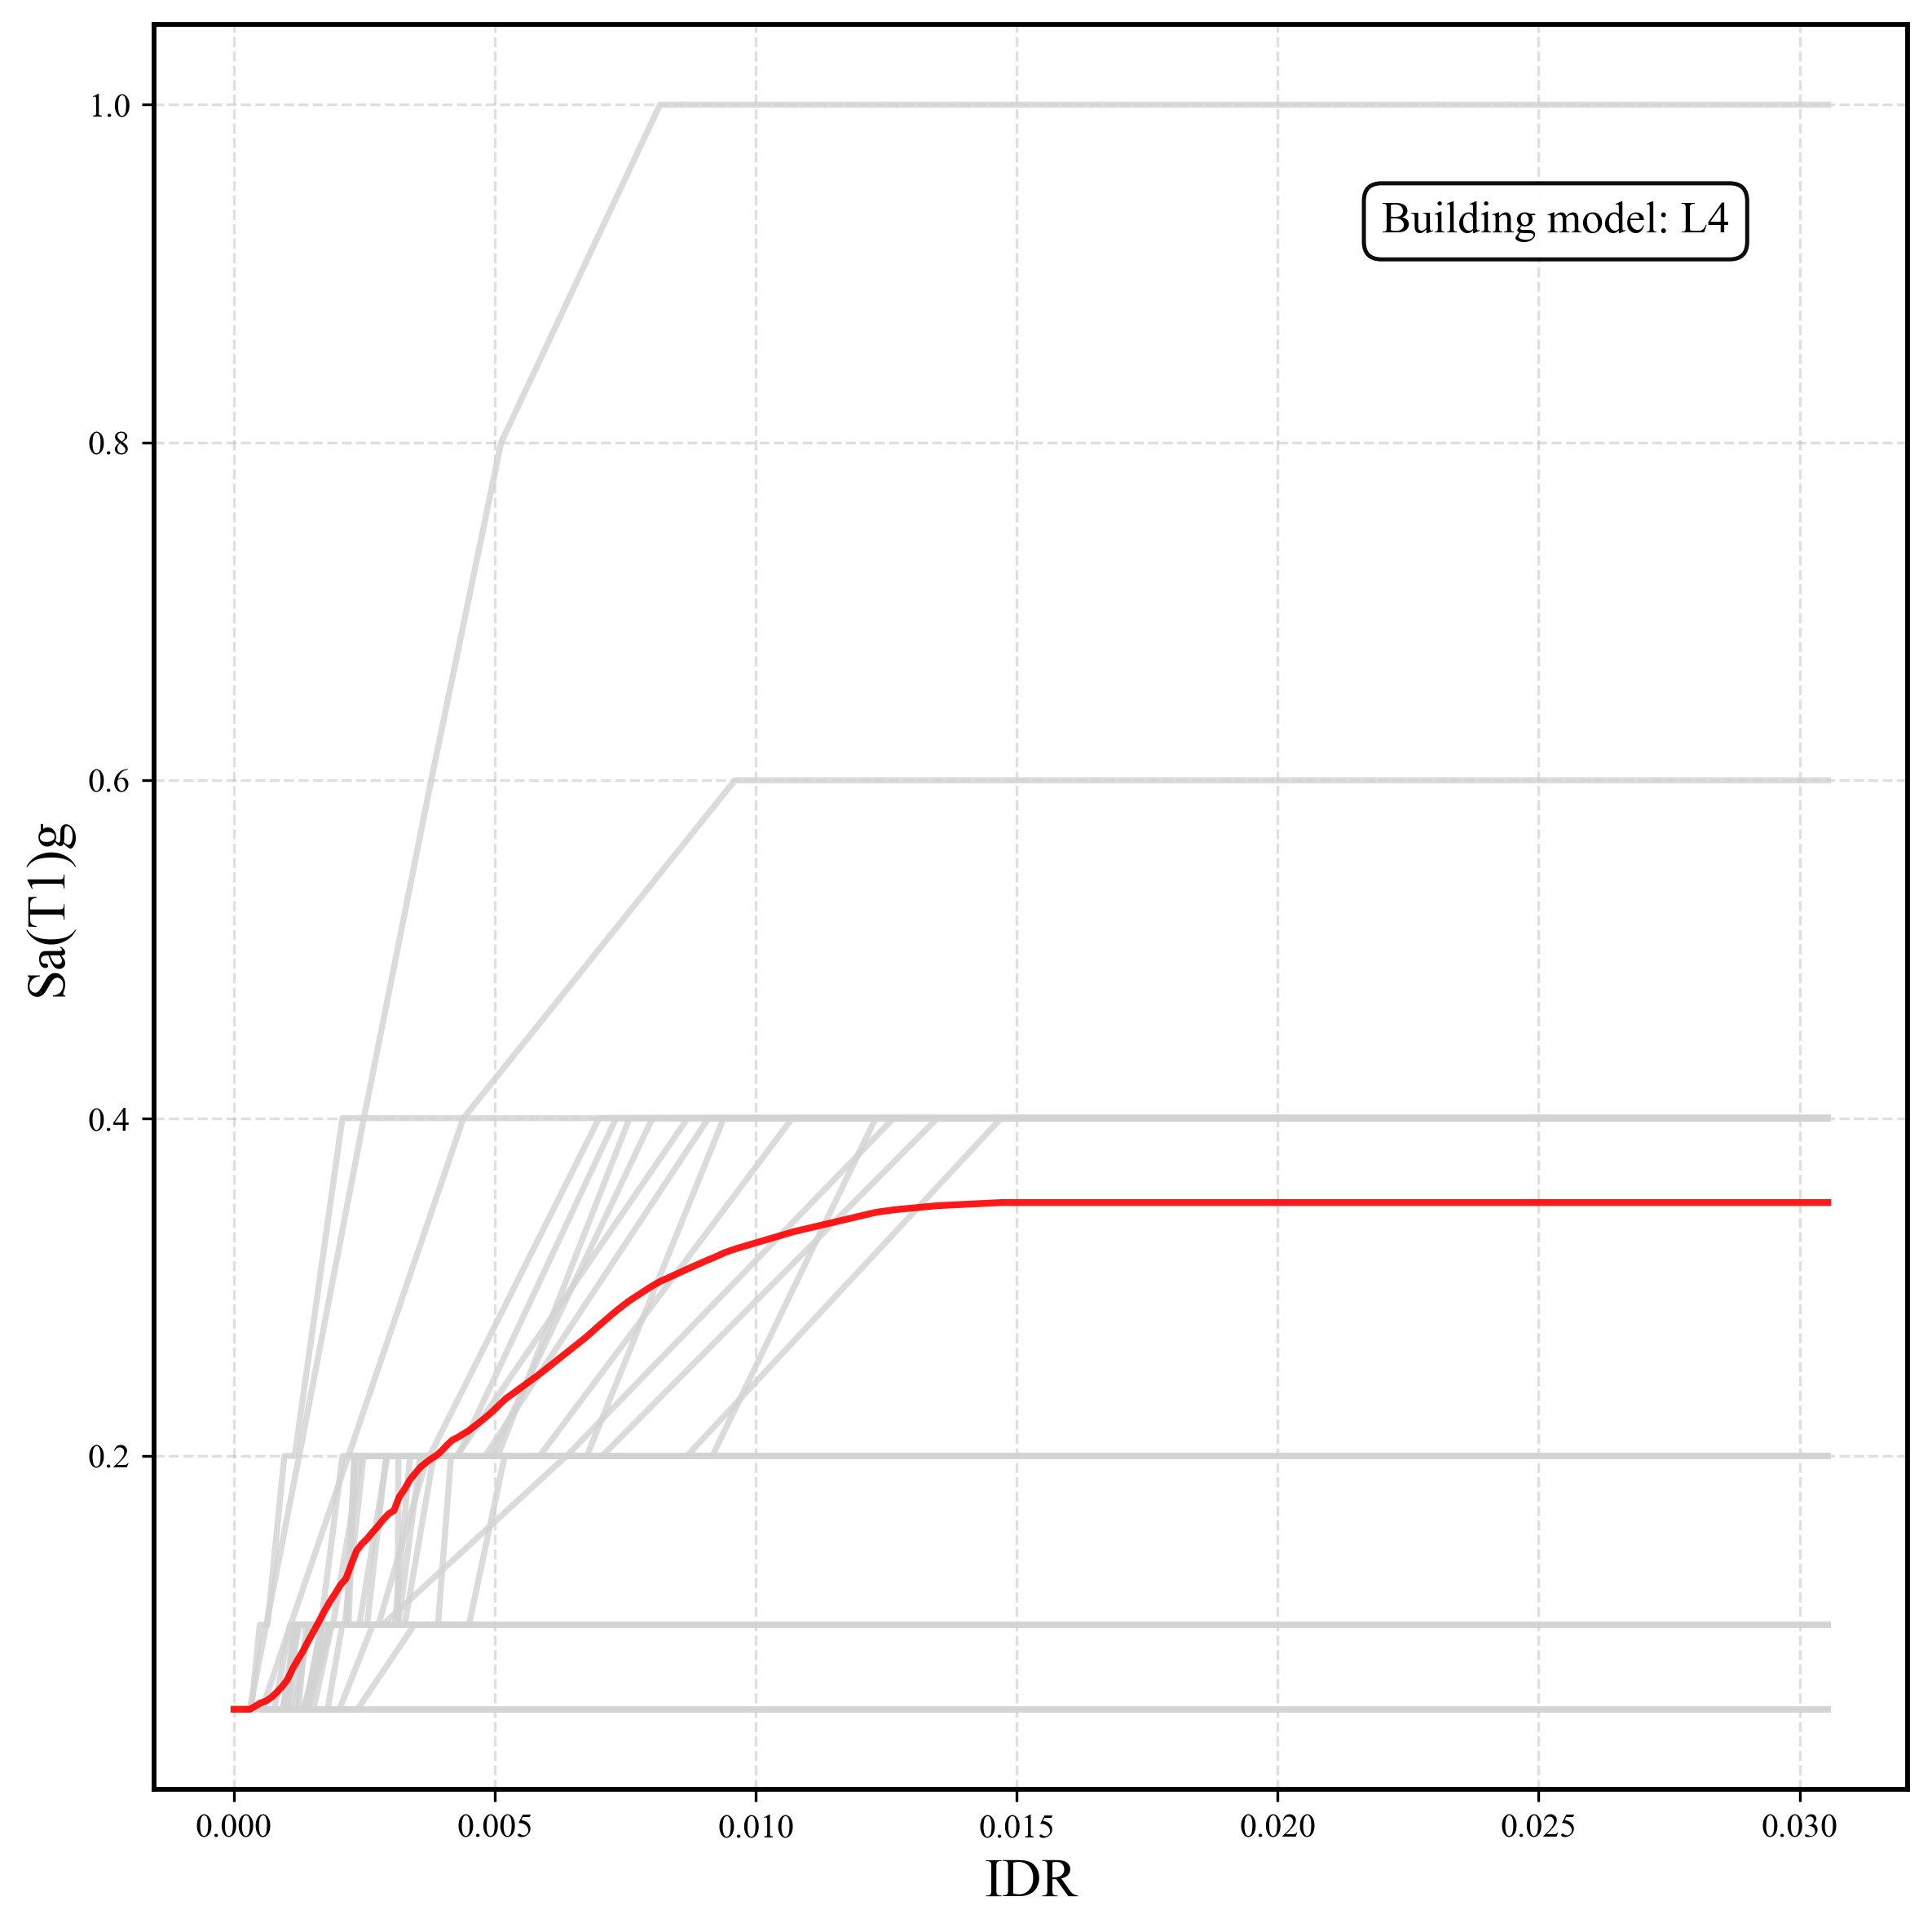

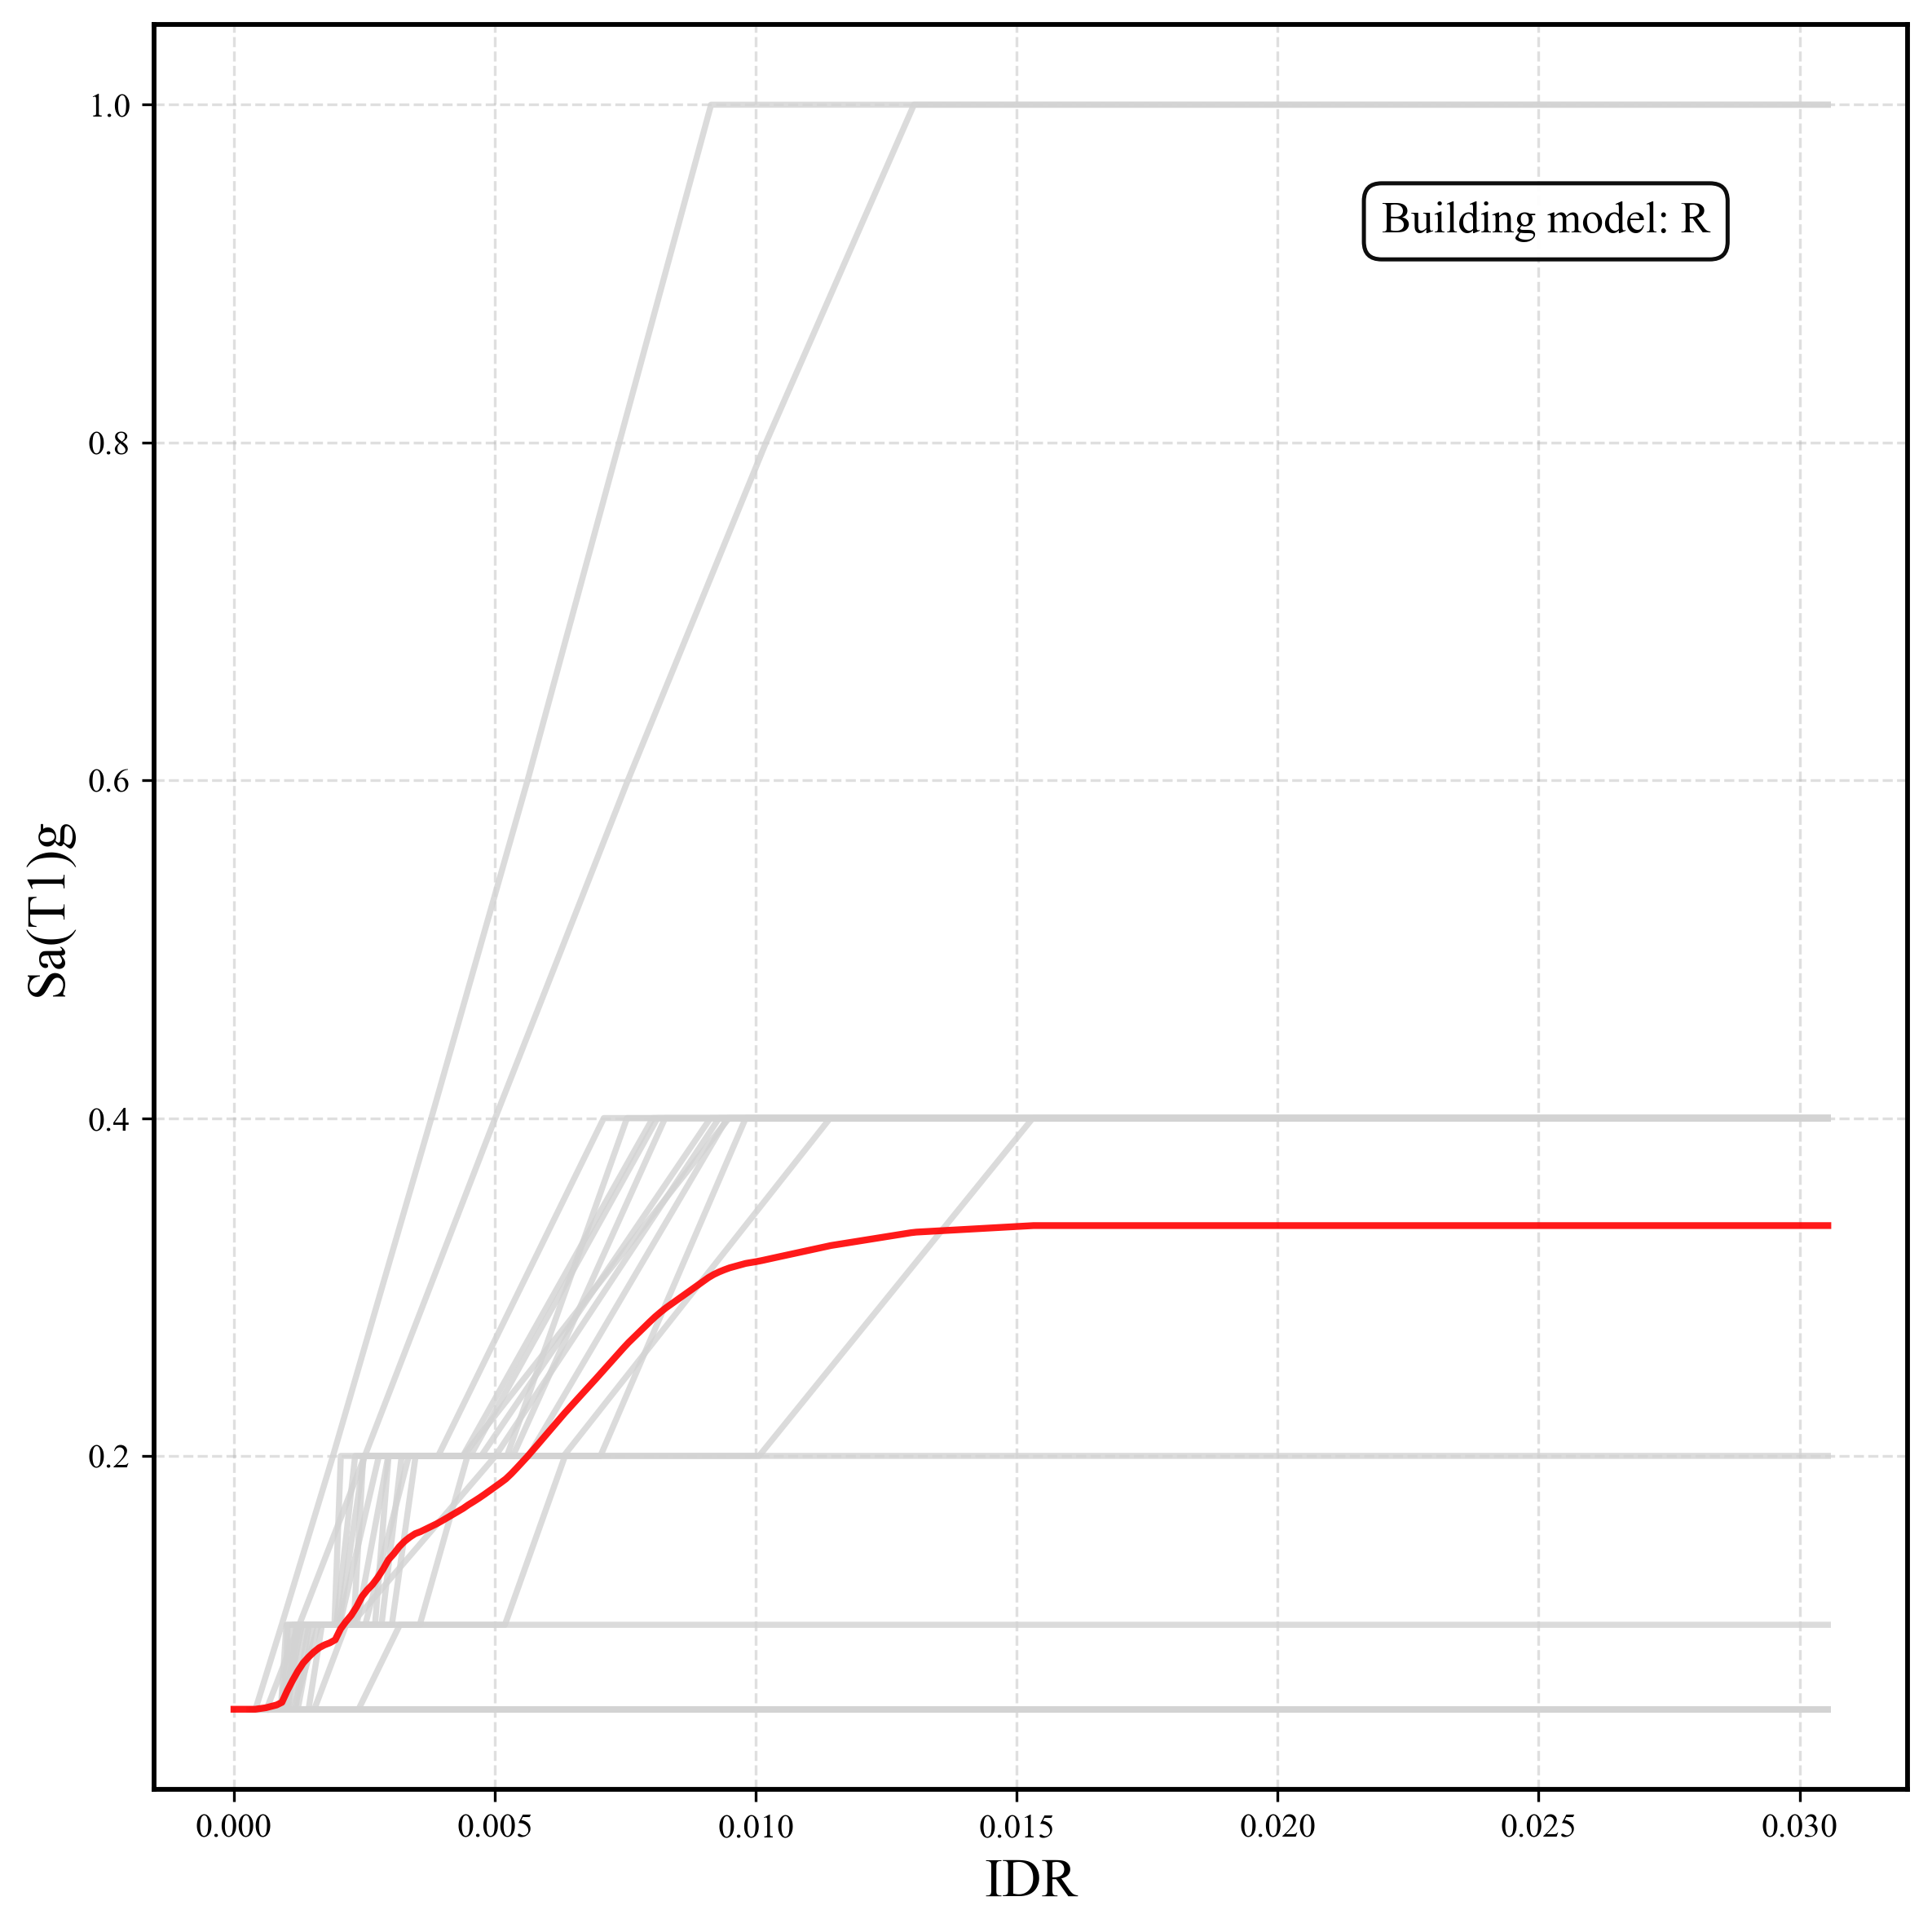

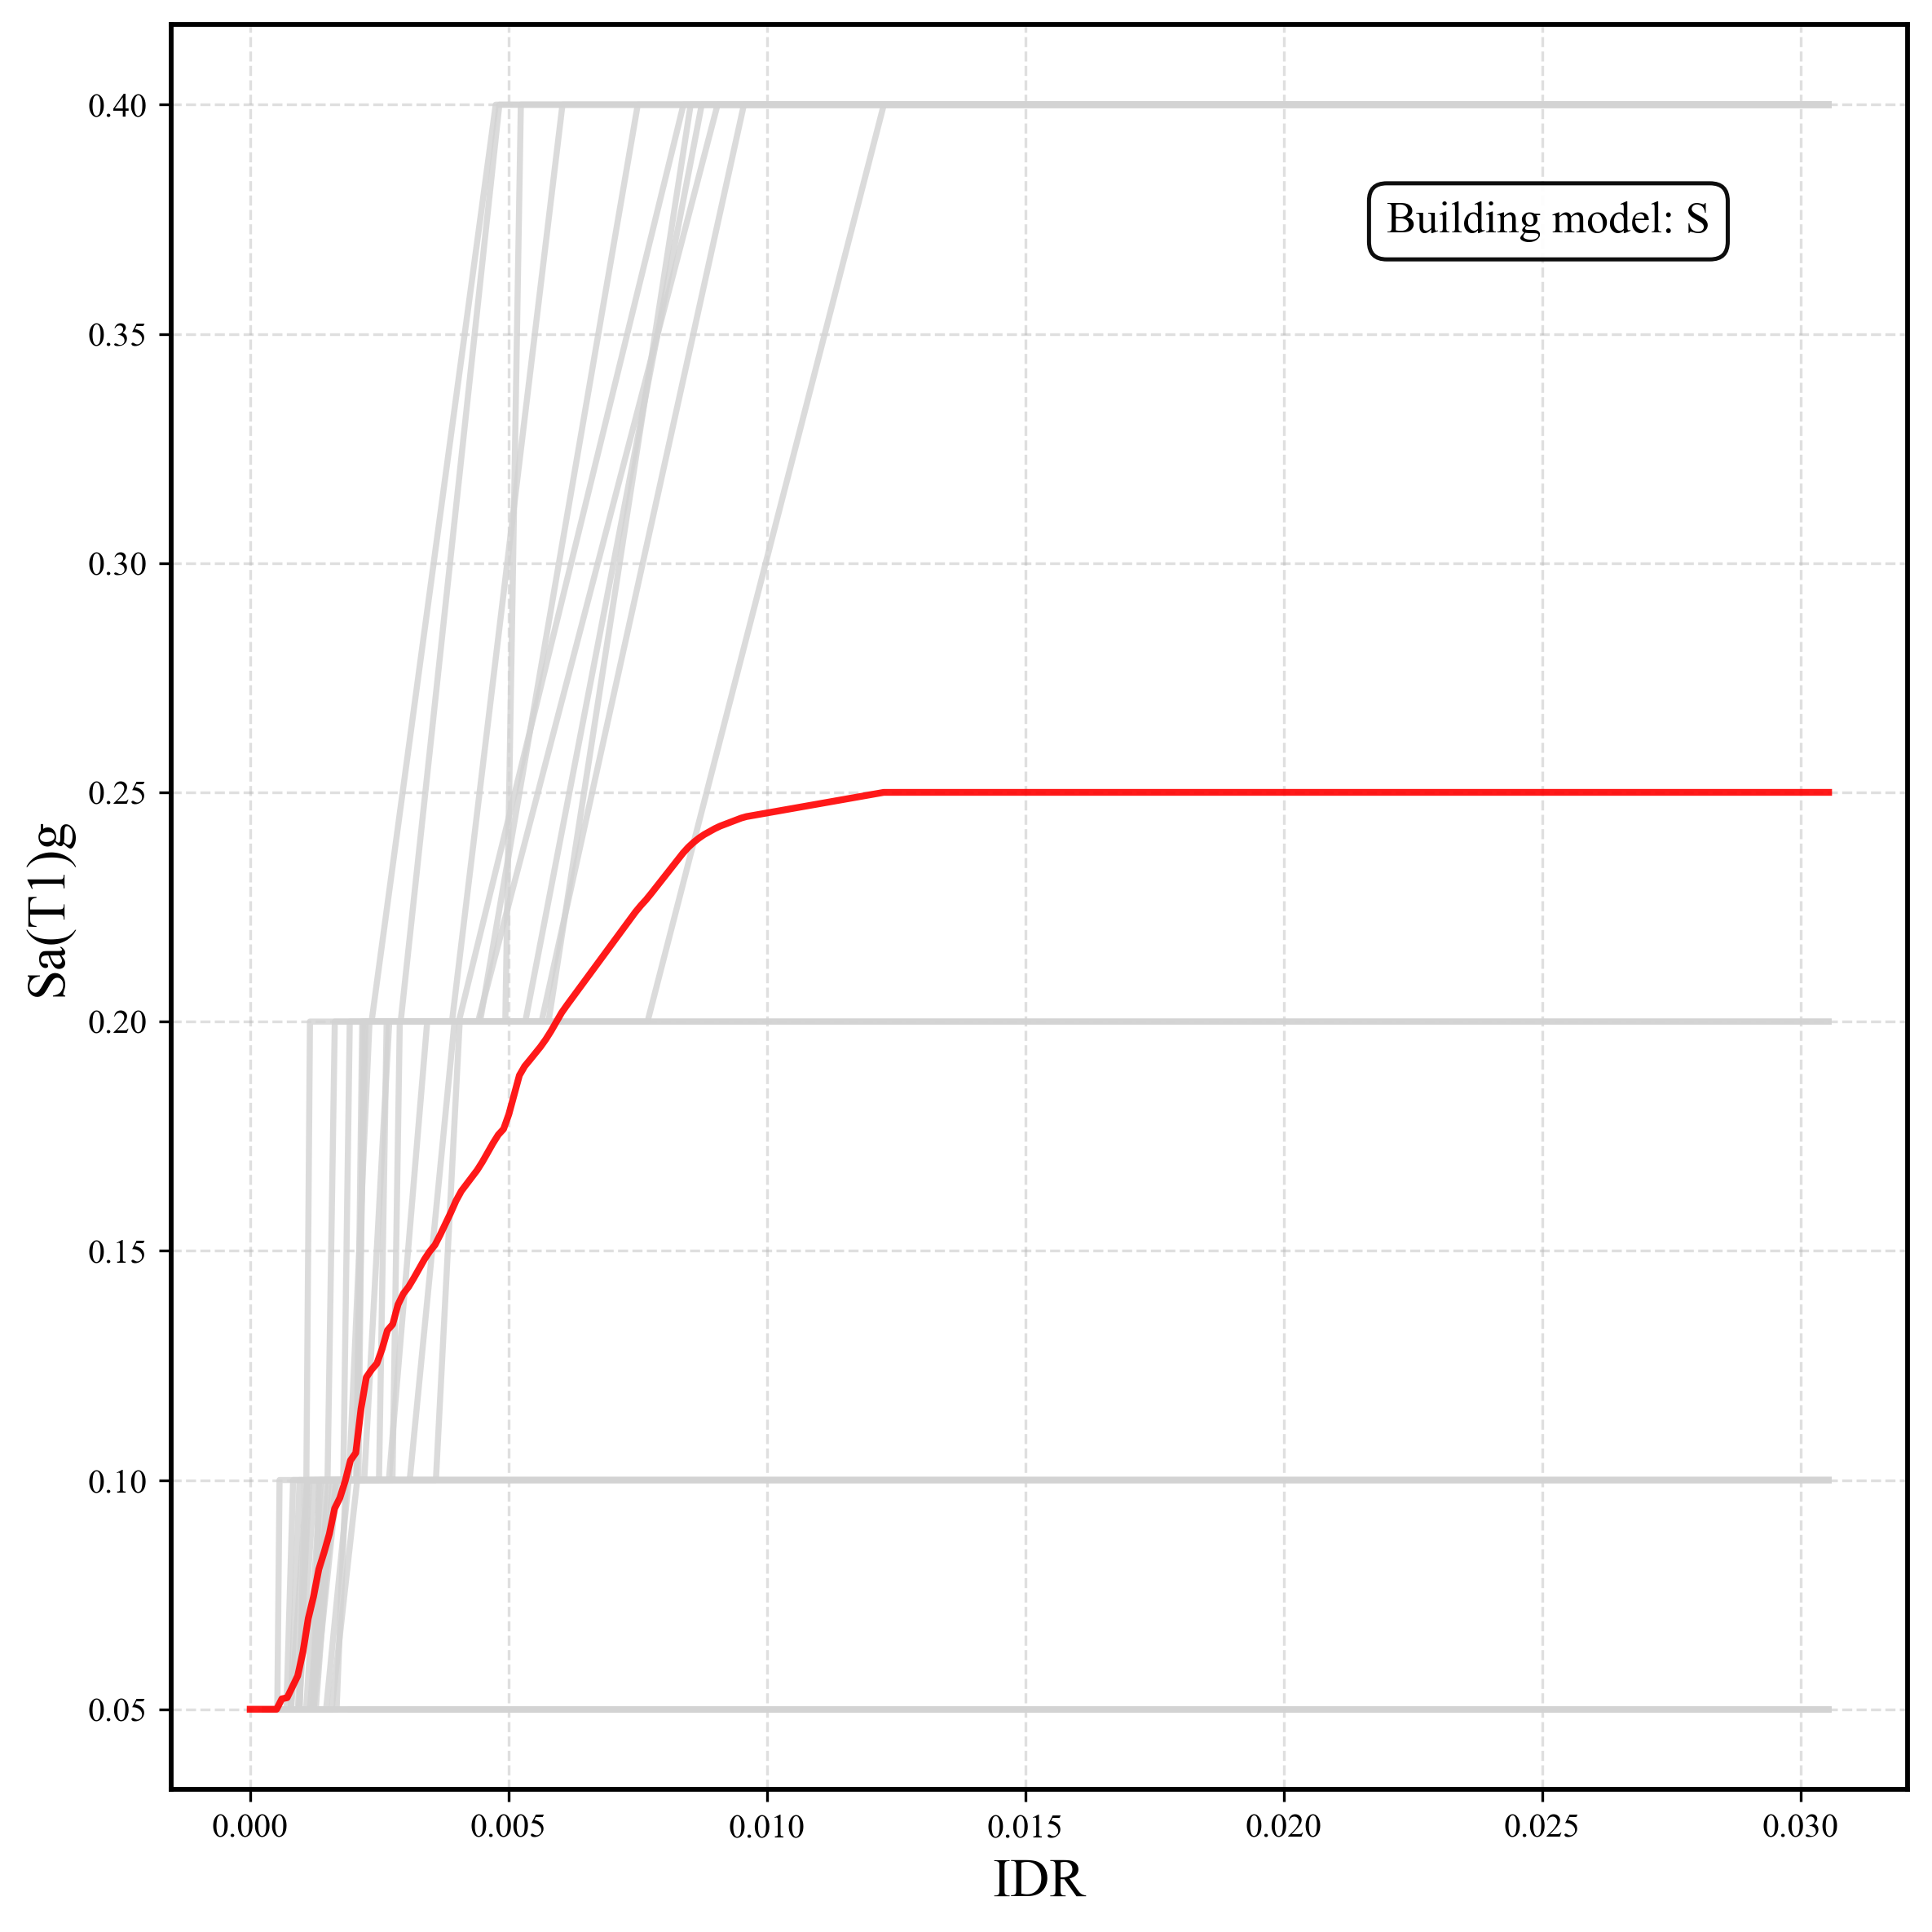

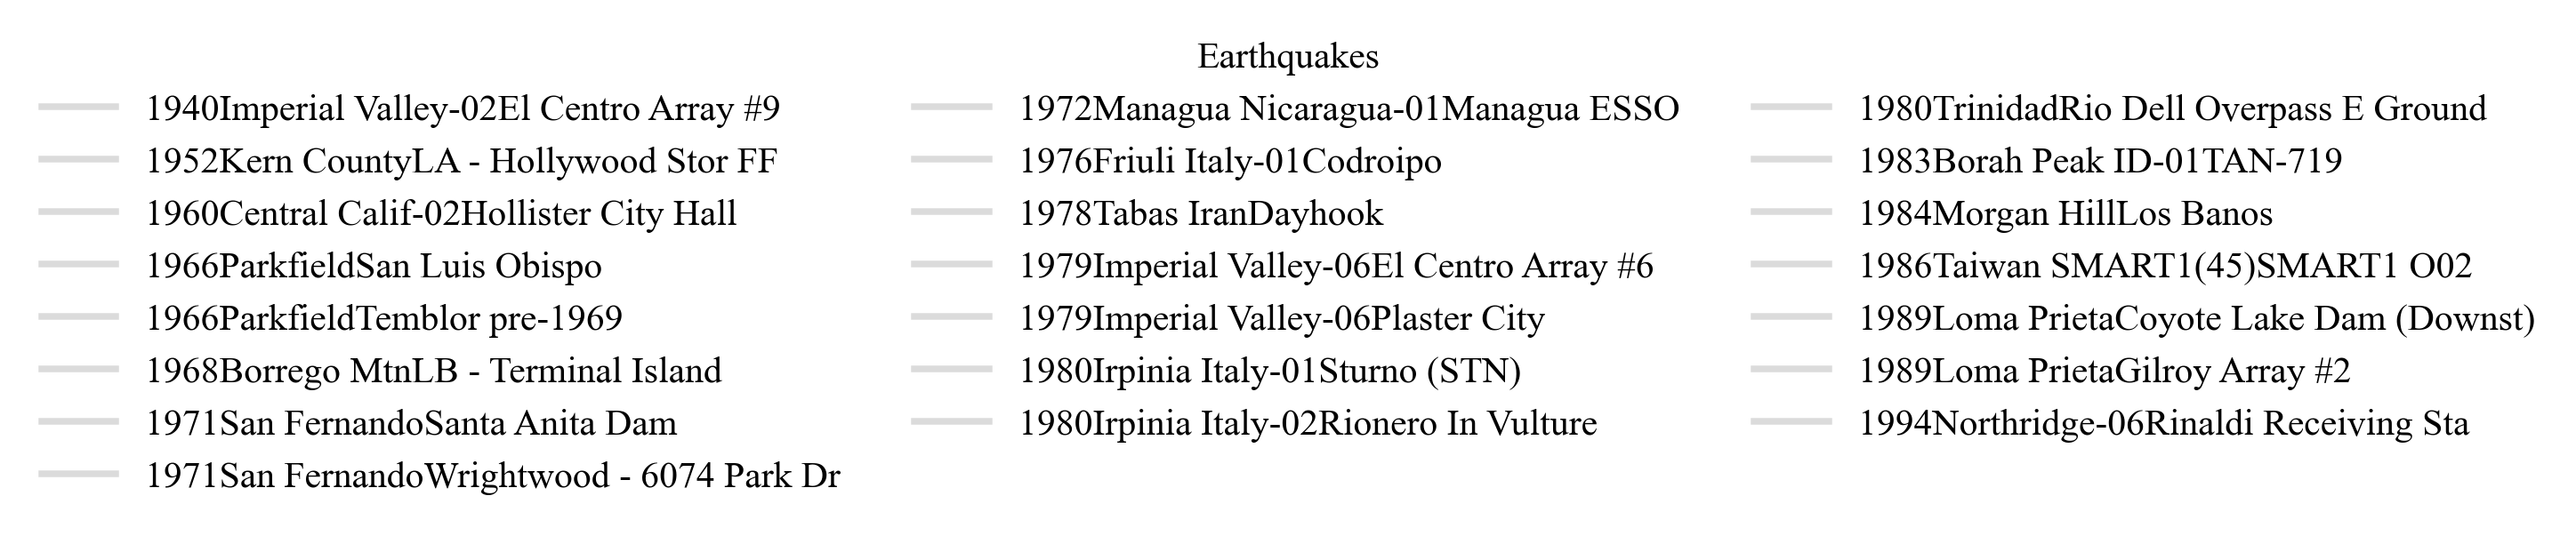

In [46]:
CreatePlots(df_numeric, "Max_Drift_X", "ScaleFactor", sortby = 'ScaleFactor', smooth = False, averageplt = True, colourPlot = False)
# # CreatePlots( "Reaction-Force-X_Level-1", 'Displacement-X_Level-6', sortby = 'Displacement-X_Level-6')

# Fragility curve Computations

In [42]:
def get_y_at_idr(df_numeric, X_Column, Y_Column, target_idr=0.01):
    
    """
    For each building and earthquake, find the y value corresponding to target_idr (x).
    Returns a dictionary of dictionaries: {building: {earthquake: y_value}}
    """
    smooth=False     #Extract from smoothen curve is set false
    Buildings = df_numeric["Building"].unique()
    Earthquakes = df_numeric["Earthquake"].unique()

    y_at_idr_dict = {}

    for building in Buildings:
        y_at_idr_dict[building] = {}
        
        # Maximum x for stretching
        x_max_building = df_numeric[df_numeric["Building"] == building][X_Column].max()

        for earthquake in Earthquakes:
            subset = df_numeric[(df_numeric["Building"] == building) &
                                (df_numeric["Earthquake"] == earthquake)]
            if subset.empty:
                continue

            subset_sorted = subset.sort_values(by=X_Column, ascending=True)
            x = subset_sorted[X_Column].values
            y = subset_sorted[Y_Column].values

            # Stretch series to max plot IDR if needed
            x_stretch, y_stretch = enforce_and_stretch_FromFirstXdecrementtoGlobalMax(x, y, x_max_building)

            # Optional smoothing
            if smooth:
                x_smooth, y_smooth = excel_smooth(x_stretch, y_stretch, points=200, tension=0.0, sortby=y_stretch)
            else:
                x_smooth, y_smooth = x_stretch, y_stretch

            # Find y corresponding to target_idr using linear interpolation
            if target_idr <= x_smooth[0]:
                y_target = y_smooth[0]
            elif target_idr >= x_smooth[-1]:
                y_target = y_smooth[-1]
            else:
                y_target = np.interp(target_idr, x_smooth, y_smooth)

            earthquake = earthquake.split("_")
            earthquake = " ".join(earthquake[0:-2])
            y_at_idr_dict[building][earthquake] = y_target

    return y_at_idr_dict
    
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np

def PlotProbabilities(
    x_values_dict,    # dict: key=building/label, value=list/array of x values (e.g., Z-scores)
    y_values_dict,    # dict: key=building/label, value=list/array of probabilities
    smooth=True,      # optional smoothing
    colors=None,      # list of colors for each building
    title="Fragility Curves",
    xlabel="X (Z-score)",
    ylabel="Probability",
    figsize=(8, 8),
    legend_title="Buildings",
    savefile="fragility_curves.png"
):
    """
    Plots multiple series from given x (Z-scores) and y (probabilities) dictionaries.

    Parameters:
        x_values_dict: dict of lists/arrays of X-axis values
        y_values_dict: dict of lists/arrays of Y-axis values
        smooth: bool, apply smoothing (optional)
        colors: list of colors for each series
        title, xlabel, ylabel: plot labels
        figsize: figure size
        legend_title: legend header
        savefile: filename to save figure
    """
    legend_handles = []
    legend_labels = []
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["axes.linewidth"] = 1.4

    fig, ax = plt.subplots(figsize=figsize)

    labels = list(x_values_dict.keys())
    n_series = len(labels)

    colors = [
        "#FF00FF", "#00FFFF", #"#7FFF00", "#39FF14", "#9B30FF",
        "#FF073A", "#1F51FF", #"#FF69B4", "#FFFF00", "#FC6C85",
        "#32CD32", "#000000",# "#333333", "#00CED1", "#00BFFF",
        "#FFBF00", "#FFAA00", #"#77DD77", "#66CDAA", "#E6E6FA",
        "#9370DB", "#4B0082"
    ]

    if colors is None:
        # default color cycle
        colors = plt.cm.tab20.colors

    for i, label in enumerate(labels):
        x = np.array(x_values_dict[label])
        y = np.array(y_values_dict[label])

        # Optional: simple smoothing via interpolation
        if smooth and len(x) > 2:
            x_new = np.linspace(np.min(x), np.max(x), 200)
            y_new = np.interp(x_new, x, y)
            x, y = x_new, y_new

        ax.plot(x, y, color=colors[i % len(colors)], lw=1.8, alpha=0.8, label=label)
        
        #Text box on the chart
        trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
        ax.text(
    0.4, 0.95,                       # → right-bottom
    f"Damage state: {title}",
    transform=trans,
    fontsize=10,
    ha="right",                       # align text to the right
    va="bottom",                      # align to bottom
    bbox=dict(
        boxstyle="round,pad=0.4",
        edgecolor="black",
        facecolor="white",
        linewidth=0.8,
        alpha=0.95
    )
)

        #For the legends extraction
        
        # if label == labels[0]:
        dummy, = ax.plot([], [], color=colors[i % len(colors)], lw=2.0)
        legend_handles.append(dummy)
        legend_labels.append(f'{label} Model')

    # ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.4)

    # ax.legend(title=legend_title, fontsize=10)
    plt.tight_layout()
        # plt.savefig("legend_only.png", dpi=300, bbox_inches="tight")
    savefile = f"{IDR}.png"

    plt.savefig(savefile, dpi=300, bbox_inches="tight")
    plt.show()
    return legend_handles, legend_labels
    
def DamageSpecificPlots(y_values_dict, upLimit =6):

      
        # ------------------------
        # STEP 1: Create column-wise dictionary
        # ------------------------
        buildings = list(y_values_dict.keys())
        earthquakes = list(next(iter(y_values_dict.values())).keys())
        
        column_dict = {}
        
        # First column = Earthquake names
        column_dict["Earthquake"] = earthquakes
        
        # Remaining columns = each building
        for building in buildings:
            column_dict[building] = [y_values_dict[building][eq] for eq in earthquakes]
        
        # ------------------------
        # STEP 2: Write table to text file
        # ------------------------
        filename = "fragility.txt"
        with open(filename, "w") as f:
            # Write header
            f.write("\t".join(column_dict.keys()) + "\n")
        
            # Write rows
            num_rows = len(column_dict["Earthquake"])
        
            for i in range(num_rows):
                row = []
                for col in column_dict.keys():
                    val = column_dict[col][i]
                    row.append(f"{val:.6f}" if isinstance(val, (int, float)) else str(val))
                f.write("\t".join(row) + "\n")
        
        print(f"Data written in tabular format to {filename}")
        # Prepare dictionaries for plotting
        z_scores_dict = {}
        probs_dict = {}
        
        vals = np.arange(0.0075, upLimit + 0.075, 0.0075)
        for key in list(column_dict.keys())[1:]:  # skip first key (e.g., "Earthquake")
            # Sort values in ascending order
            sorted_vals = sorted(column_dict[key])
            
            # Take natural log
            ln_vals = [np.log(v) for v in sorted_vals]
        
            # # Compute mean and sample std
            mean_ln = np.mean(ln_vals)
            std_ln = np.std(ln_vals, ddof=1)  # n-1
        
        
            # Compute Z-scores for vals
            z_scores = (np.log(vals) - mean_ln) / std_ln
        
            # Compute cumulative probability for each Z-score
            probs = norm.cdf(z_scores)
        
            # Store in dictionaries
            z_scores_dict[key] = vals      # You can use Z-scores or original vals for X-axis
            probs_dict[key] = probs
        
        # Now plot using the function
        legend_handles, legend_labels = PlotProbabilities(
            x_values_dict=z_scores_dict,
            y_values_dict=probs_dict,
            smooth=True,
            title= IDR,
            xlabel="Value",
            ylabel="Probability"
        )
        return legend_handles, legend_labels
    
def BuildingSpecificFragilityPlots(df_numeric, X_Column, Y_Column, Damagestates, smooth=True, boundshatch = True, boundsLine = True):
    """
    Create building-specific fragility plots.
    Each plot shows all damage state curves for that building.
    
    Parameters:
    - df_numeric: DataFrame with building & earthquake data
    - X_Column: Column name for IDR (x-axis)
    - Y_Column: Column name for response (y-axis)
    - Damagestates: dict of damage states { "IO": [target_x, upLimit], ... }
    - smooth: bool, whether to smooth curves
    """
        # ------------------------
        # STEP 1: Create column-wise dictionary
        # ------------------------
    legend_handles = []
    legend_labels = []
    column_dict = {}
    colors = [
        "#00FFFF", "#FF00FF",  "#0FFF00", "#39FF14", "#9B30FF",
       "#FF073A", "#1F51FF", "#FF69B4", "#FFFF00", "#FC6C85",
        "#32CD32", "#000000", "#333333", "#00CED1", "#00BFFF",
        "#FFBF00", "#FFAA00","#77DD77", "#66CDAA", "#E6E6FA",
       "#9370DB", "#4B0082"
    ]

    for idx, (state, (target_idr, upLimit)) in enumerate(Damagestates.items()):
        y_values_dict = get_y_at_idr(df_numeric, "Max_Drift_X", "ScaleFactor", target_idr=target_idr )
        column_dict[state] = {}
        buildings = list(y_values_dict.keys())
        earthquakes = list(next(iter(y_values_dict.values())).keys())
        # First column = Earthquake names
        column_dict[state]["Earthquake"] = earthquakes
        # Remaining columns = each building
        for building in buildings:
            column_dict[state][building] = [y_values_dict[building][eq] for eq in earthquakes]
            
    upLimit = 6
    for building in buildings:
        fig, ax = plt.subplots(figsize=(8, 8))
        for idx, Damagestate in enumerate(list(column_dict.keys())):
            earthquakes = column_dict[state]["Earthquake"]
            
            probs_dict = {}
            # print(earthquakes)
            mainvalues = column_dict[Damagestate][building]

            # Calculate fragility probabilities
            vals = np.arange(0.0075, upLimit + 0.0075, 0.0075)
            sorted_vals = sorted(mainvalues)
            ln_vals = [np.log(v) for v in sorted_vals]
            mean_ln = np.mean(ln_vals)
            std_ln = np.std(ln_vals, ddof=1)

            z_scores = (np.log(vals) - mean_ln) / std_ln
            probs = norm.cdf(z_scores)

            x_vals = vals
            y_vals = probs
            
            if smooth:
                x_vals, y_vals = excel_smooth(x_vals, y_vals, points=60, tension=0.0, sortby=y_vals)
            ax.plot(x_vals, y_vals, color=colors[idx], lw=1.8, alpha=0.7, label=f"{Damagestate}")  # Label only once per state

            #Text box on the chart
            trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
            ax.text(
    0.80, 0.5,                       # → right-bottom
    f"Building model: {building}",
    transform=trans,
    fontsize=10,
    ha="right",                       # align text to the right
    va="bottom",                      # align to bottom
    bbox=dict(
        boxstyle="round,pad=0.4",
        edgecolor="black",
        facecolor="white",
        linewidth=0.8,
        alpha=0.95
    )
)
            #For creating the legend on next plot
            # ax.plot(x_vals, y_vals, color=colors[idx], lw=2.0, alpha=0.85)
            # Add legend item only once (for the first building)
            if building == Buildings[0]:
                dummy, = ax.plot([], [], color=colors[idx], lw=2.0)
                legend_handles.append(dummy)
                legend_labels.append(Damagestate)
            
            n = len(sorted_vals)   # number of samples

            #BOunds
            if boundshatch:
                # 95% confidence interval for μ (log-mean)
                mu_lower = mean_ln - 1.96 * (std_ln / np.sqrt(n))
                mu_upper = mean_ln + 1.96 * (std_ln / np.sqrt(n))
                
                # Compute bound curves
                z_lower = (np.log(vals) - mu_lower) / std_ln
                z_upper = (np.log(vals) - mu_upper) / std_ln
                
                probs_lower = norm.cdf(z_lower)
                probs_upper = norm.cdf(z_upper)
                
                # # Plot the curves
                # ax.plot(x_vals, y_vals, color=colors[idx], lw=1.8, alpha=0.9, label=f"{Damagestate}")
                
                # Fill only around the damage state curve
                ax.fill_between(vals, probs_lower, probs_upper,
                                color=colors[idx], alpha=0.25, label=f"{Damagestate} 95% CI")
            if boundsLine:
                                # Confidence interval for μ (log-mean)
                mu_lower = mean_ln - 1.96 * (std_ln / np.sqrt(n))
                mu_upper = mean_ln + 1.96 * (std_ln / np.sqrt(n))
                
                # Convert CI → probability bounds
                z_lower = (np.log(vals) - mu_lower) / std_ln
                z_upper = (np.log(vals) - mu_upper) / std_ln
                
                probs_lower = norm.cdf(z_lower)
                probs_upper = norm.cdf(z_upper)
                
                # # Plot main curve
                # ax.plot(x_vals, y_vals, color=colors[idx], lw=2.0, alpha=0.9, label=f"{Damagestate}")
                
                # Plot bounds as thin dotted lines
                ax.plot(vals, probs_lower, color=colors[idx], lw=1.0, ls="--", alpha=0.7, label=f"{Damagestate} 95% confidence bounds")
                ax.plot(vals, probs_upper, color=colors[idx], lw=1.0, ls="--", alpha=0.7)
                
                            # Add legend item only once (for the first building)
                if building == Buildings[0]:
                    dummy, = ax.plot([], [], color=colors[idx], lw=2.0)
                    legend_handles.append(dummy)
                    legend_labels.append(f"{Damagestate} 95% confidence bounds")

                

        ax.set_xlabel("PGA (g)", fontsize=14)
        ax.set_ylabel("Probability of exceedance", fontsize=14)
        # ax.set_title(f"Fragility Curves for {building}", fontsize=16)
        ax.grid(True, linestyle="dashed", alpha=0.4)

        plt.tight_layout()
        plt.savefig(f"SETA_SFupto4_{building}.png", dpi=300, bbox_inches="tight")

        plt.show()

    return legend_handles, legend_labels

def SaveLegendOnly(legend_handles, legend_labels, filename="legend_only.png"):
        fig, ax = plt.subplots(figsize=(6, 0.6))
        ax.axis("off")
     # ax.legend(title=legend_title, fontsize=10)
        ax.legend(legend_handles, legend_labels, loc="center", ncol=6, frameon=False, title="Buildings", fontsize=12)
        plt.savefig("legend_only.png", dpi=300, bbox_inches="tight")
        


Data written in tabular format to fragility.txt


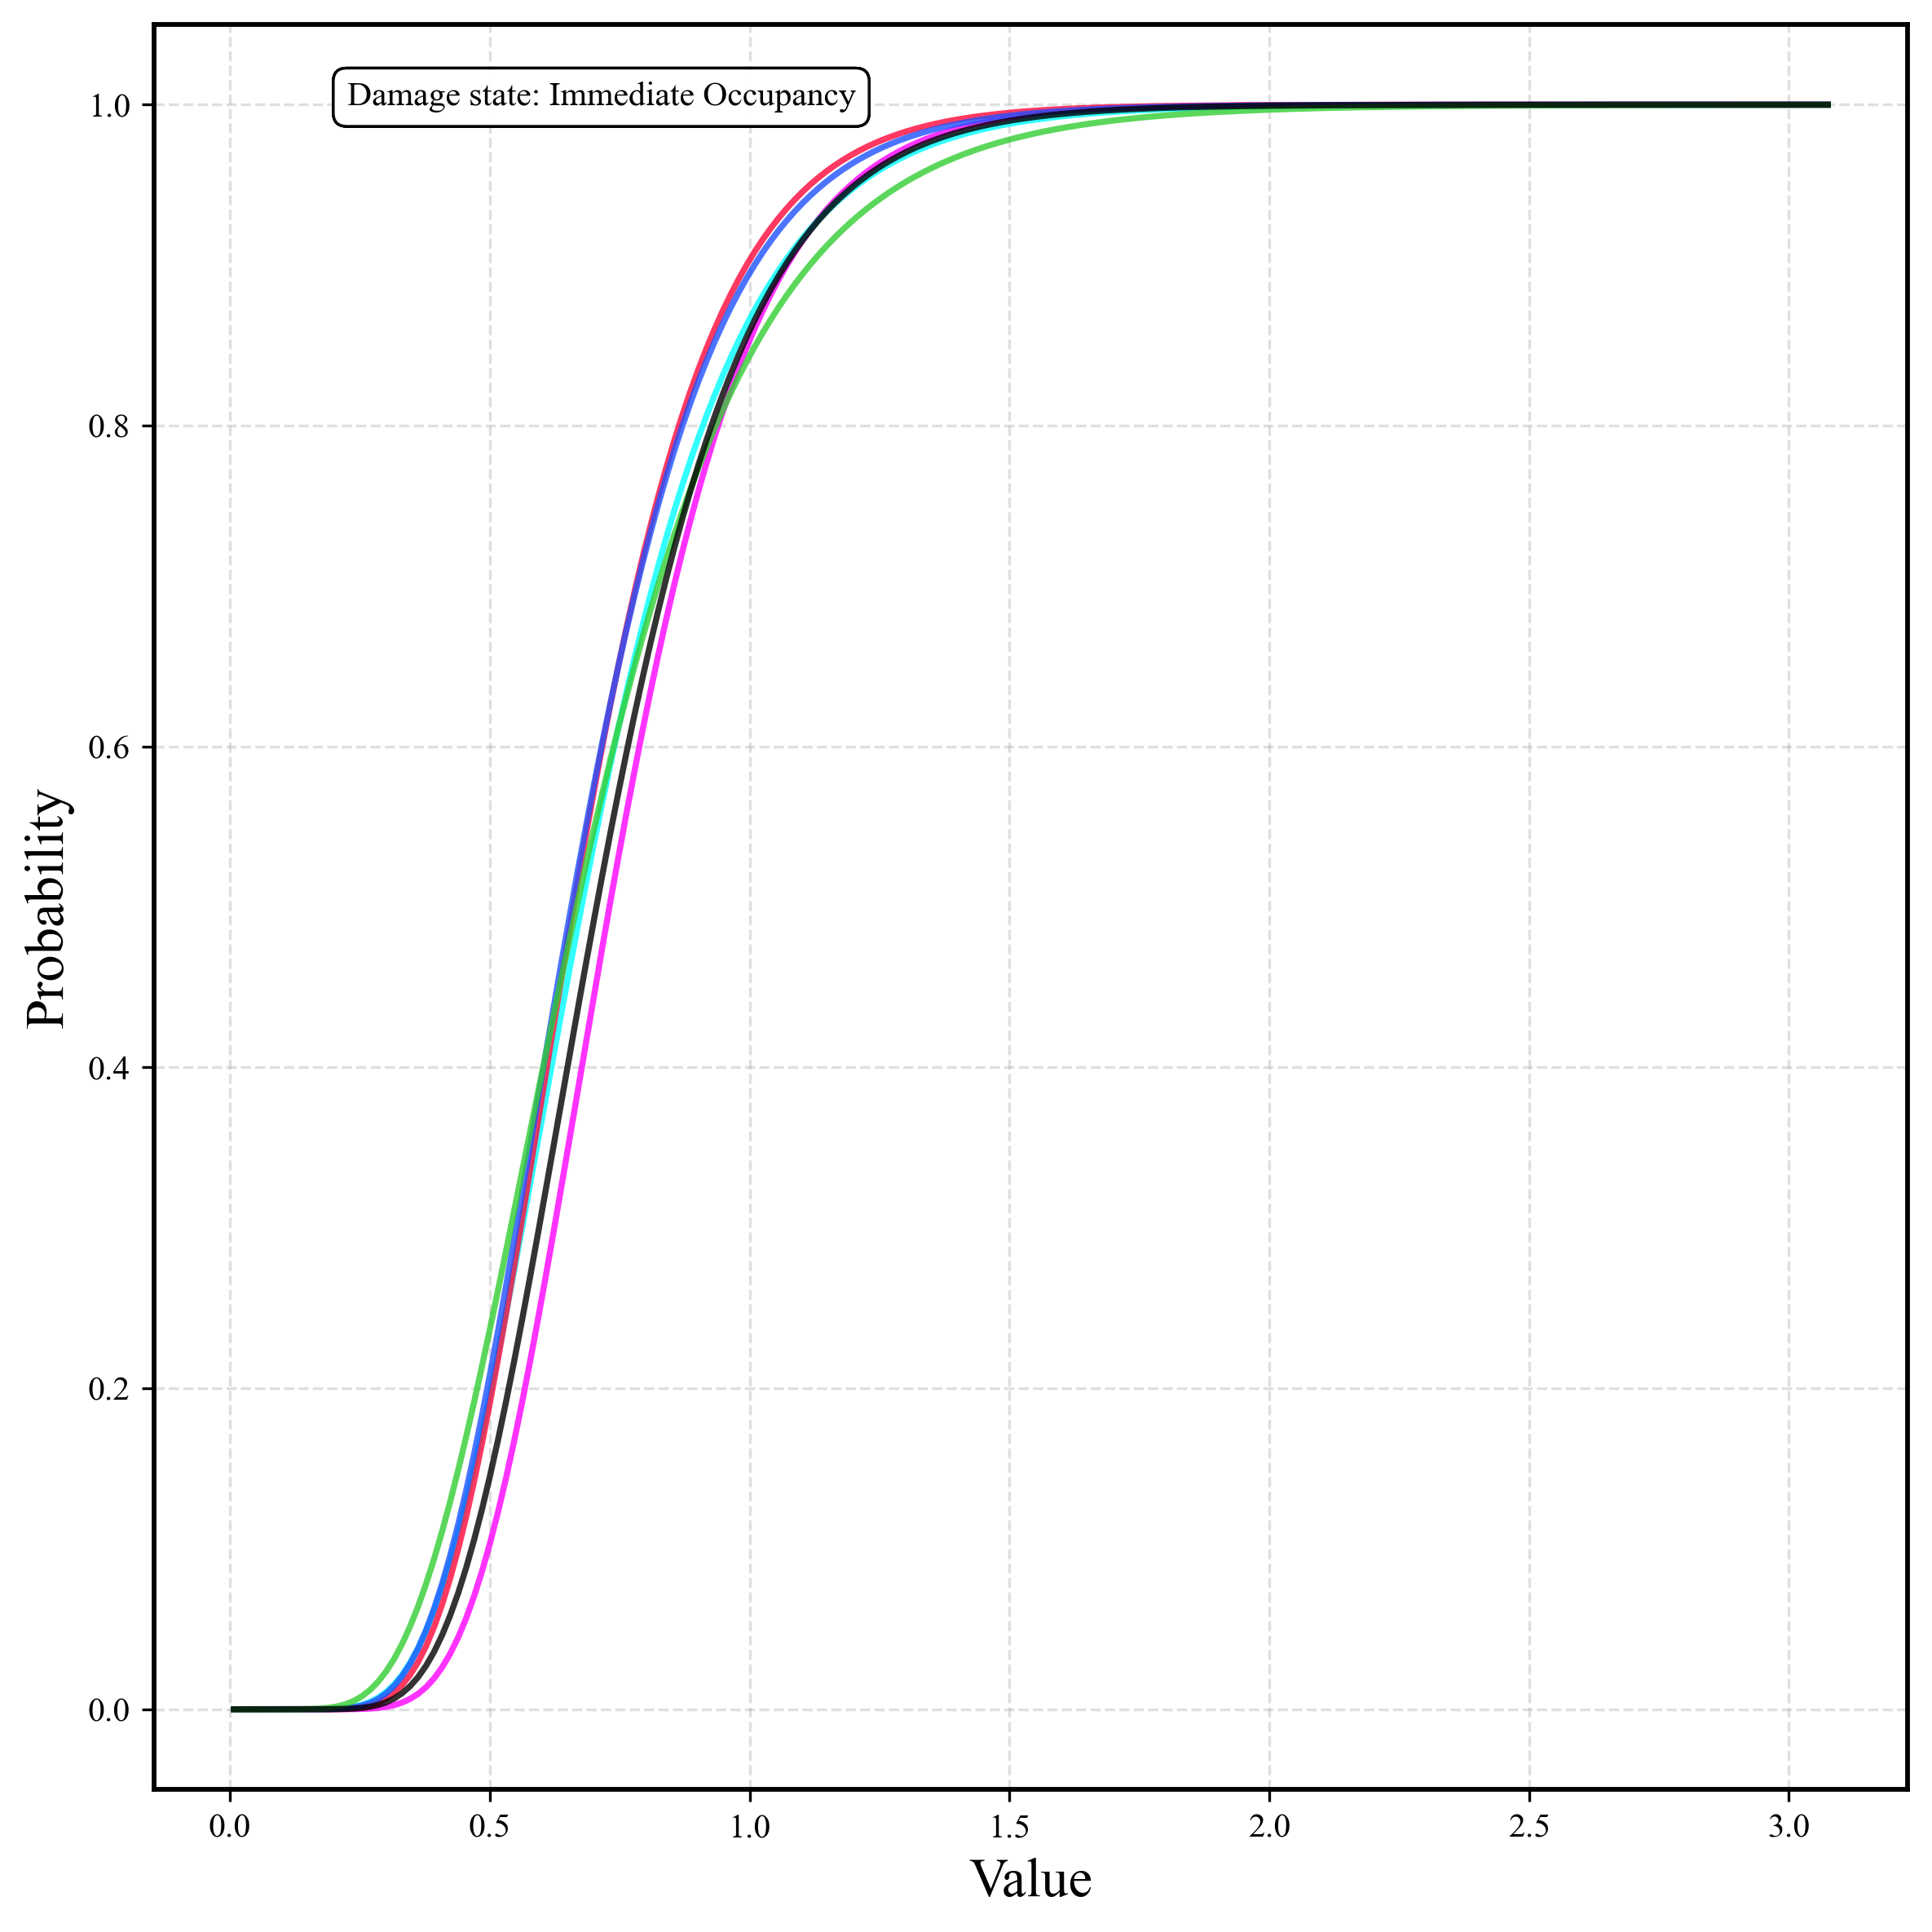

Data written in tabular format to fragility.txt


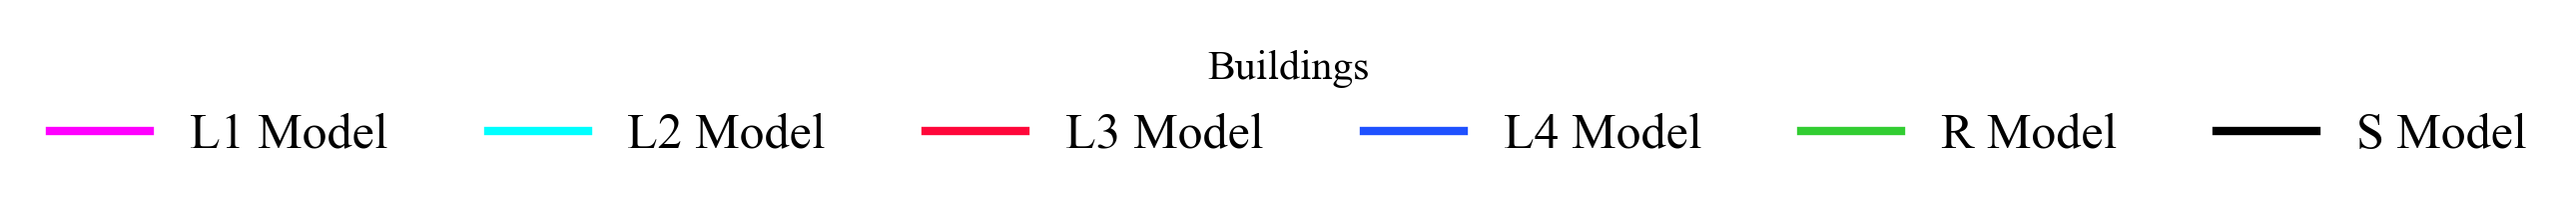

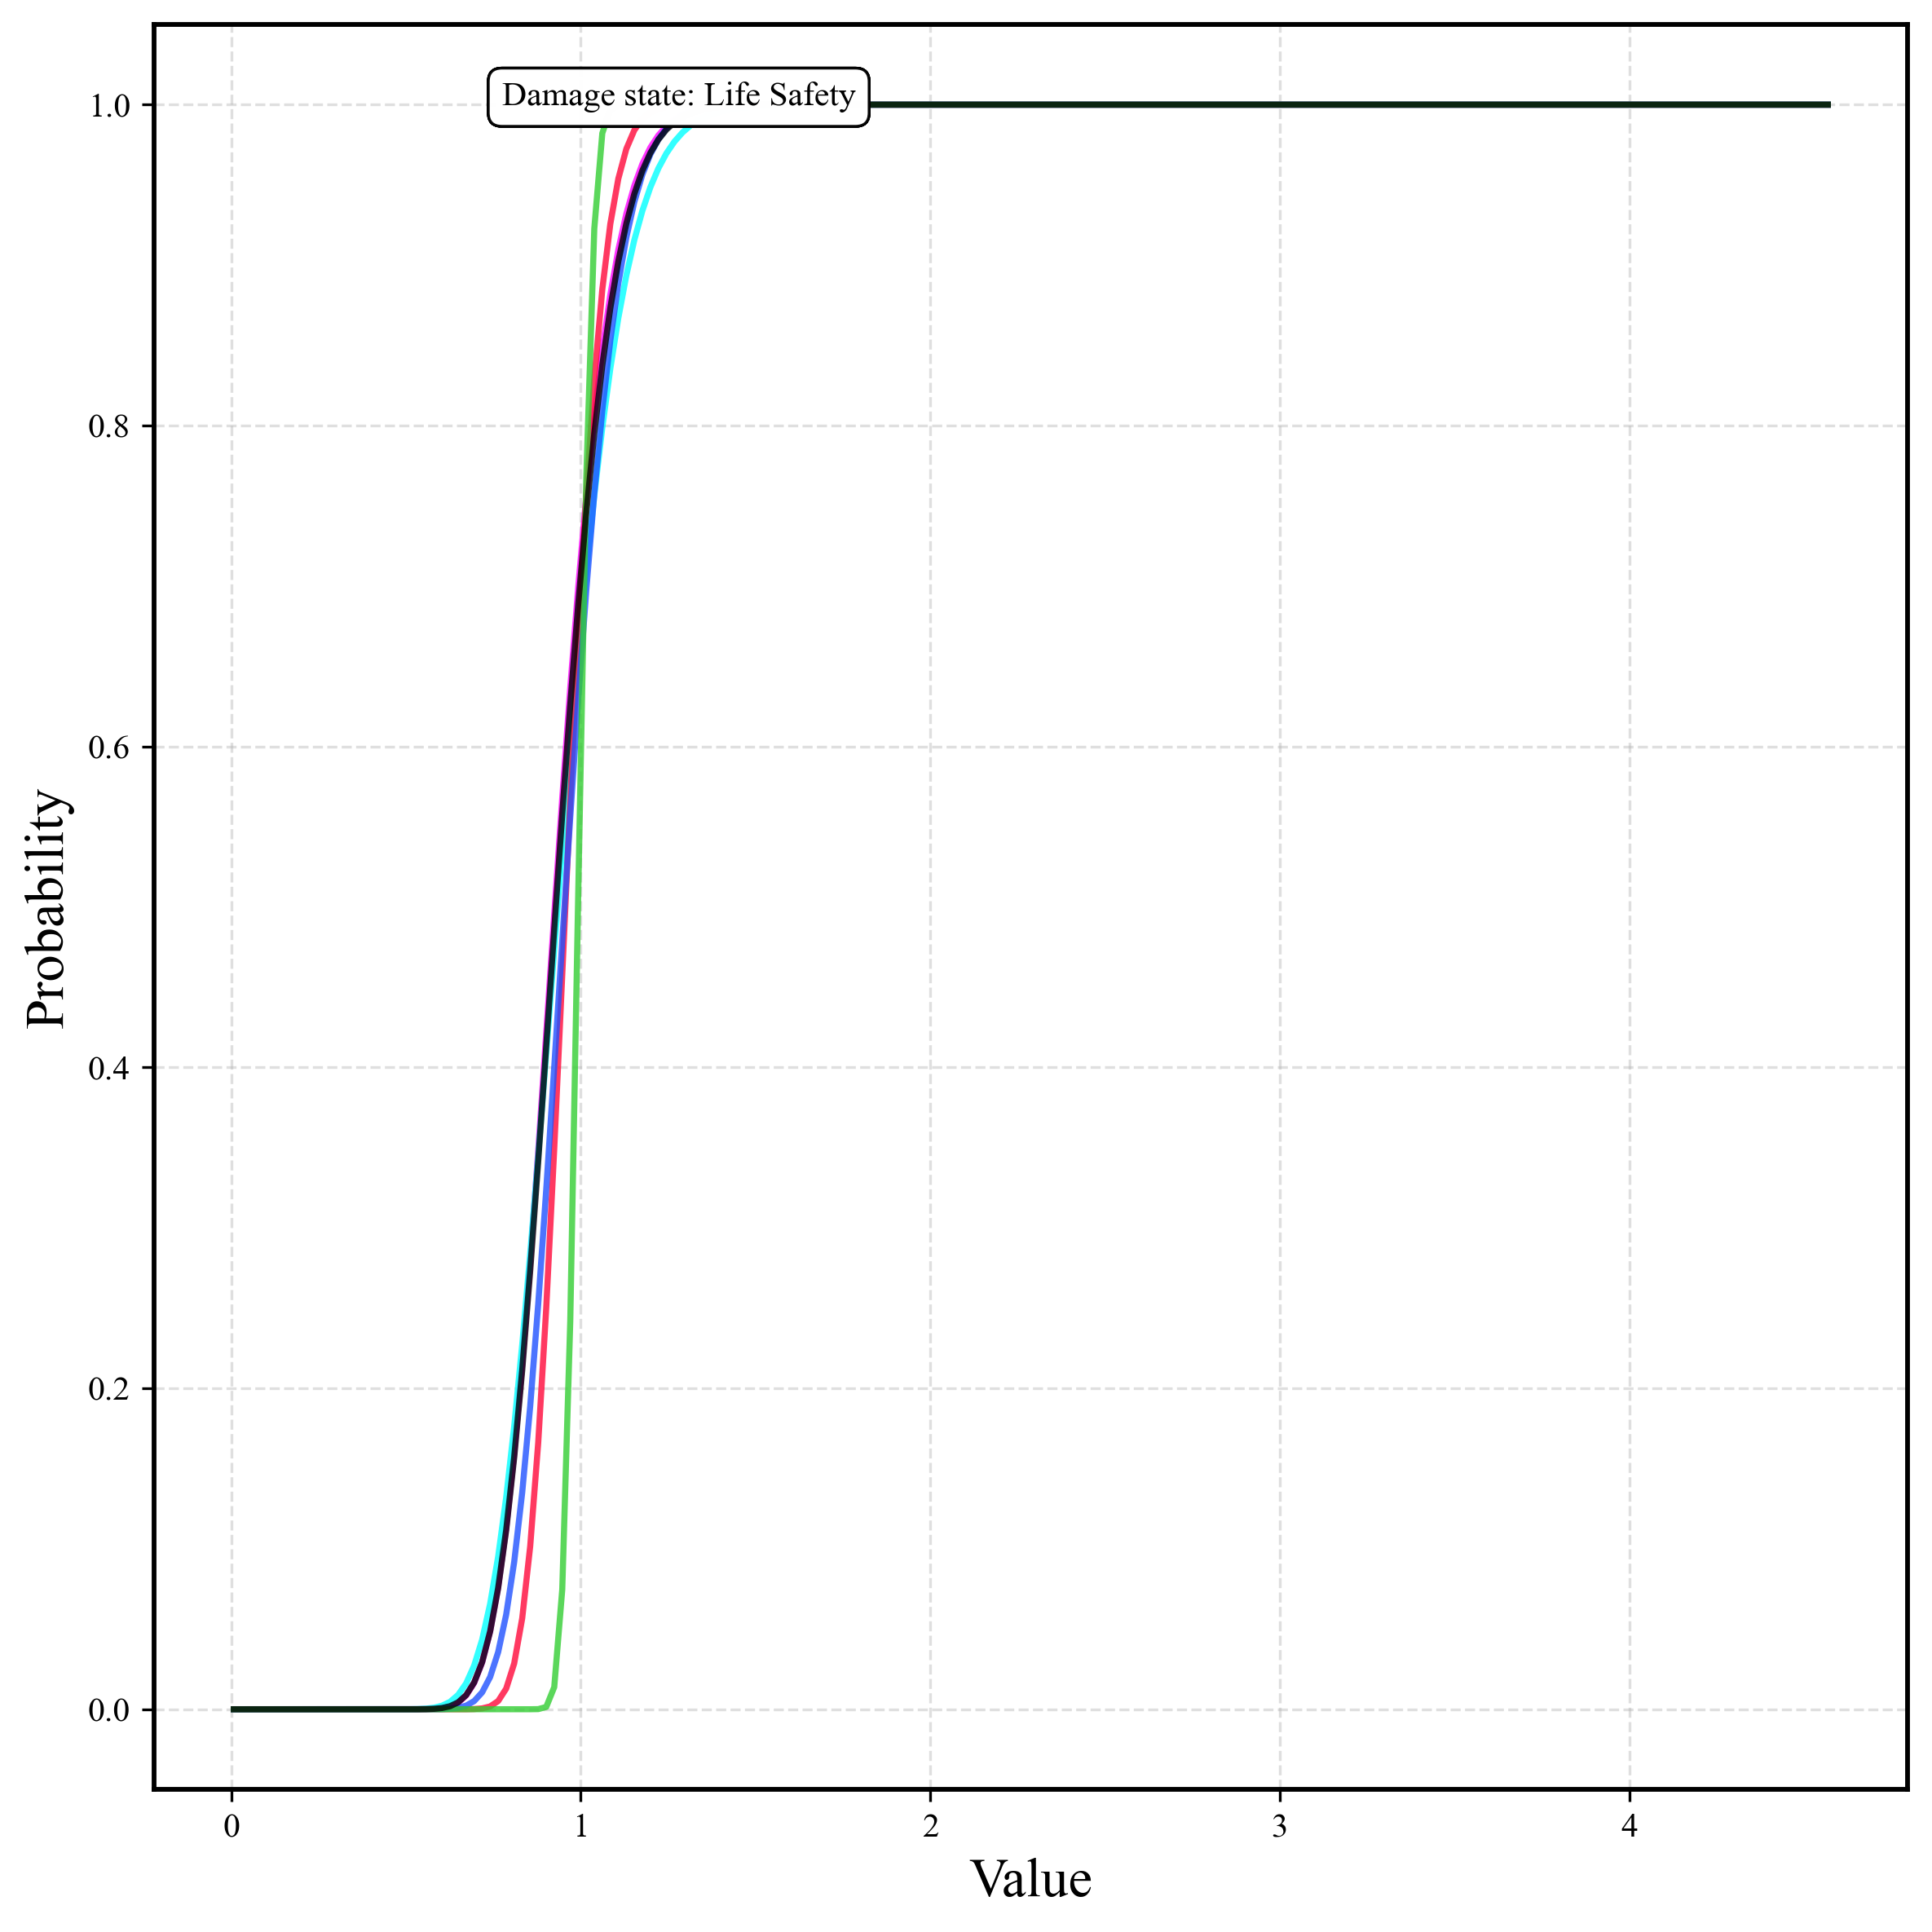

Data written in tabular format to fragility.txt


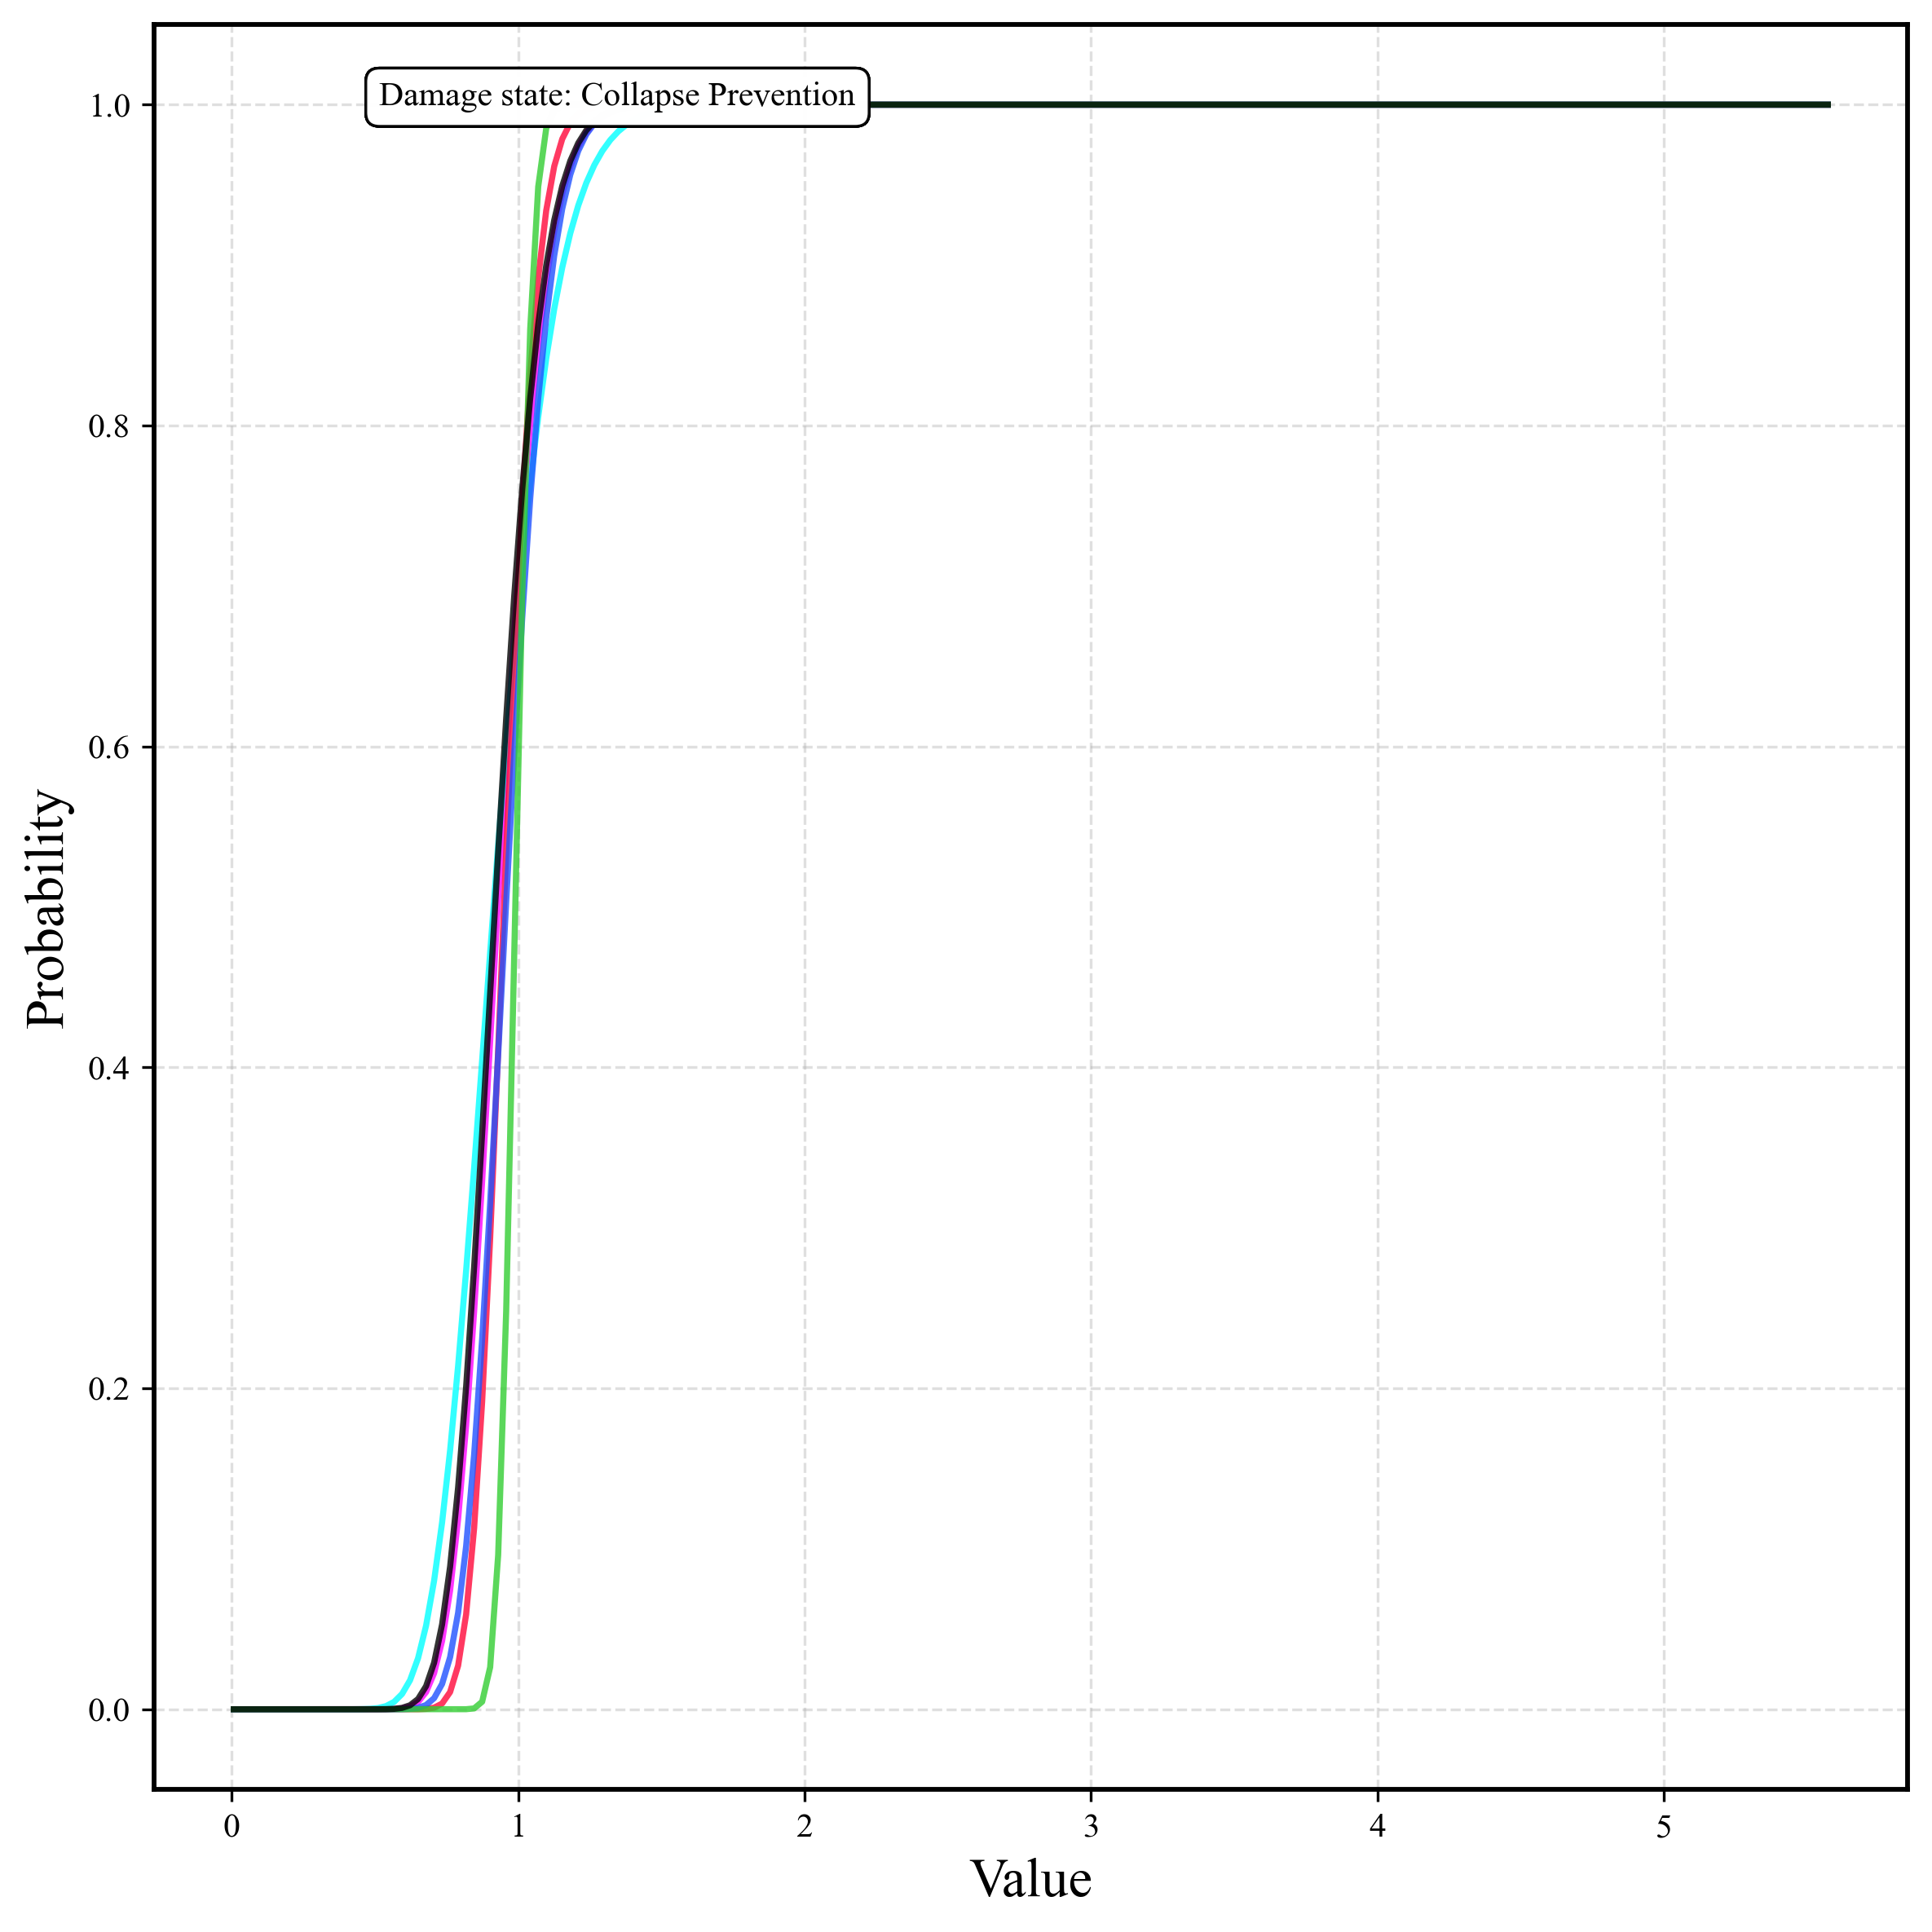

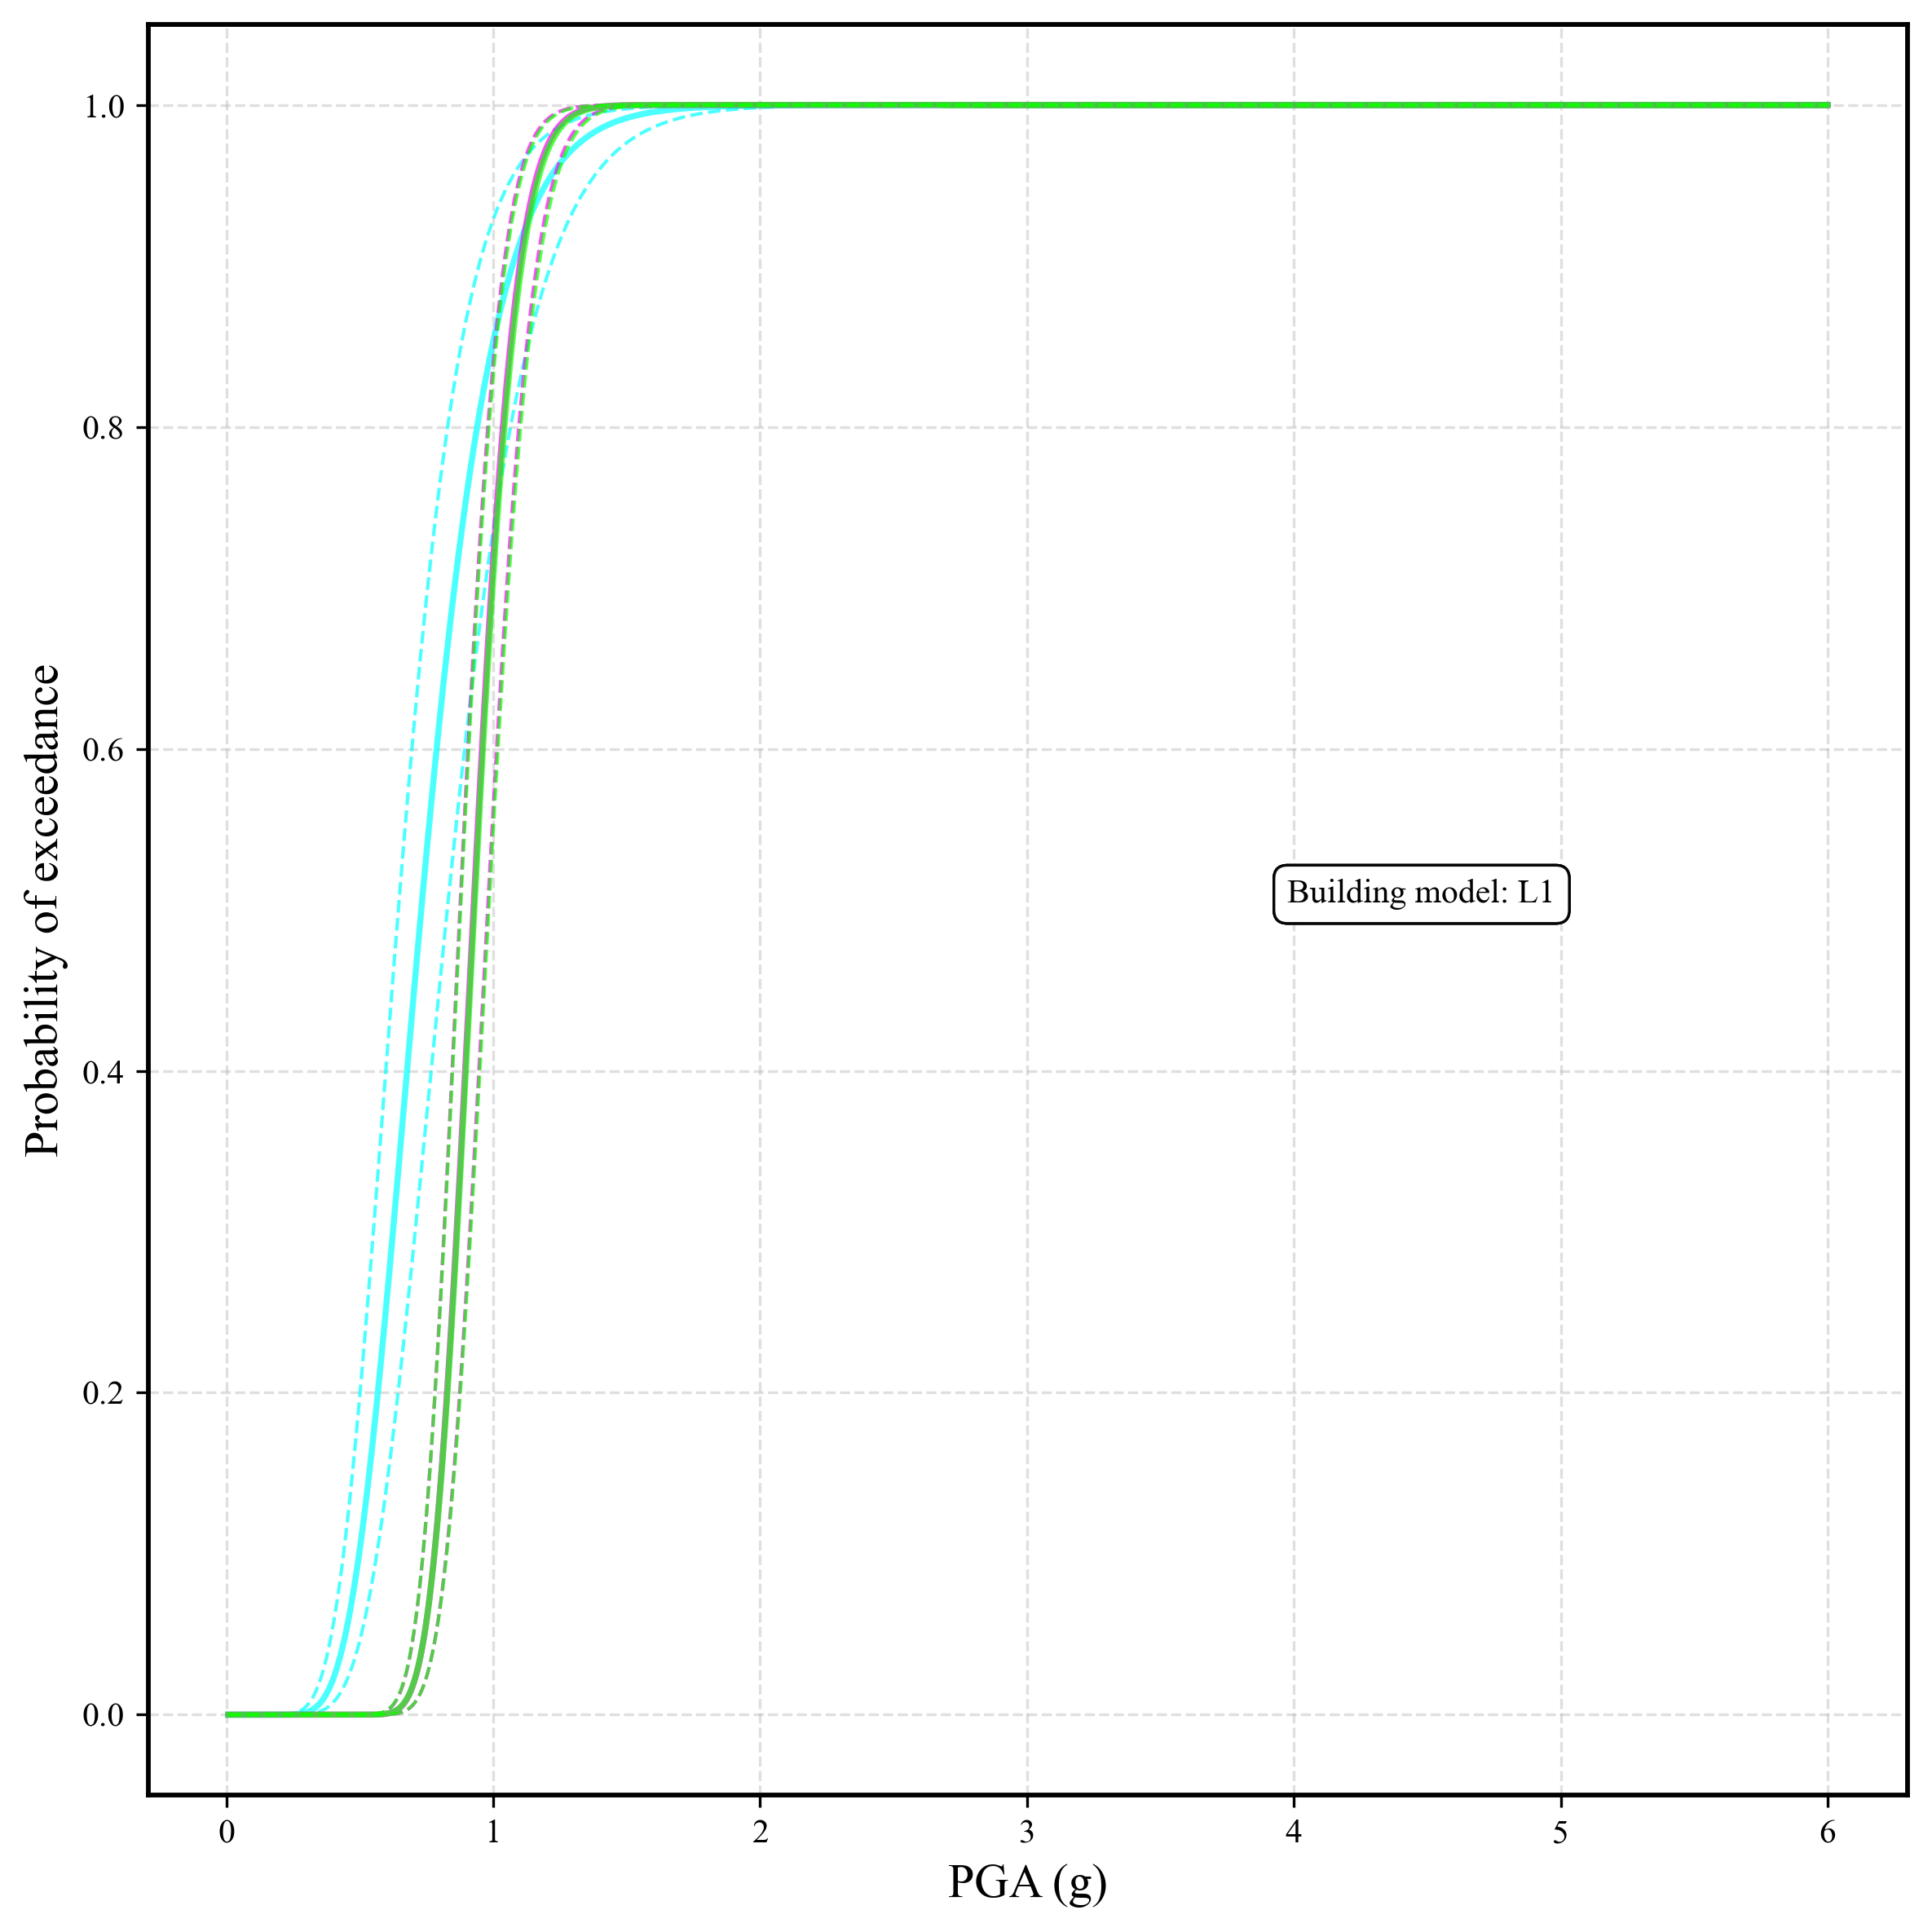

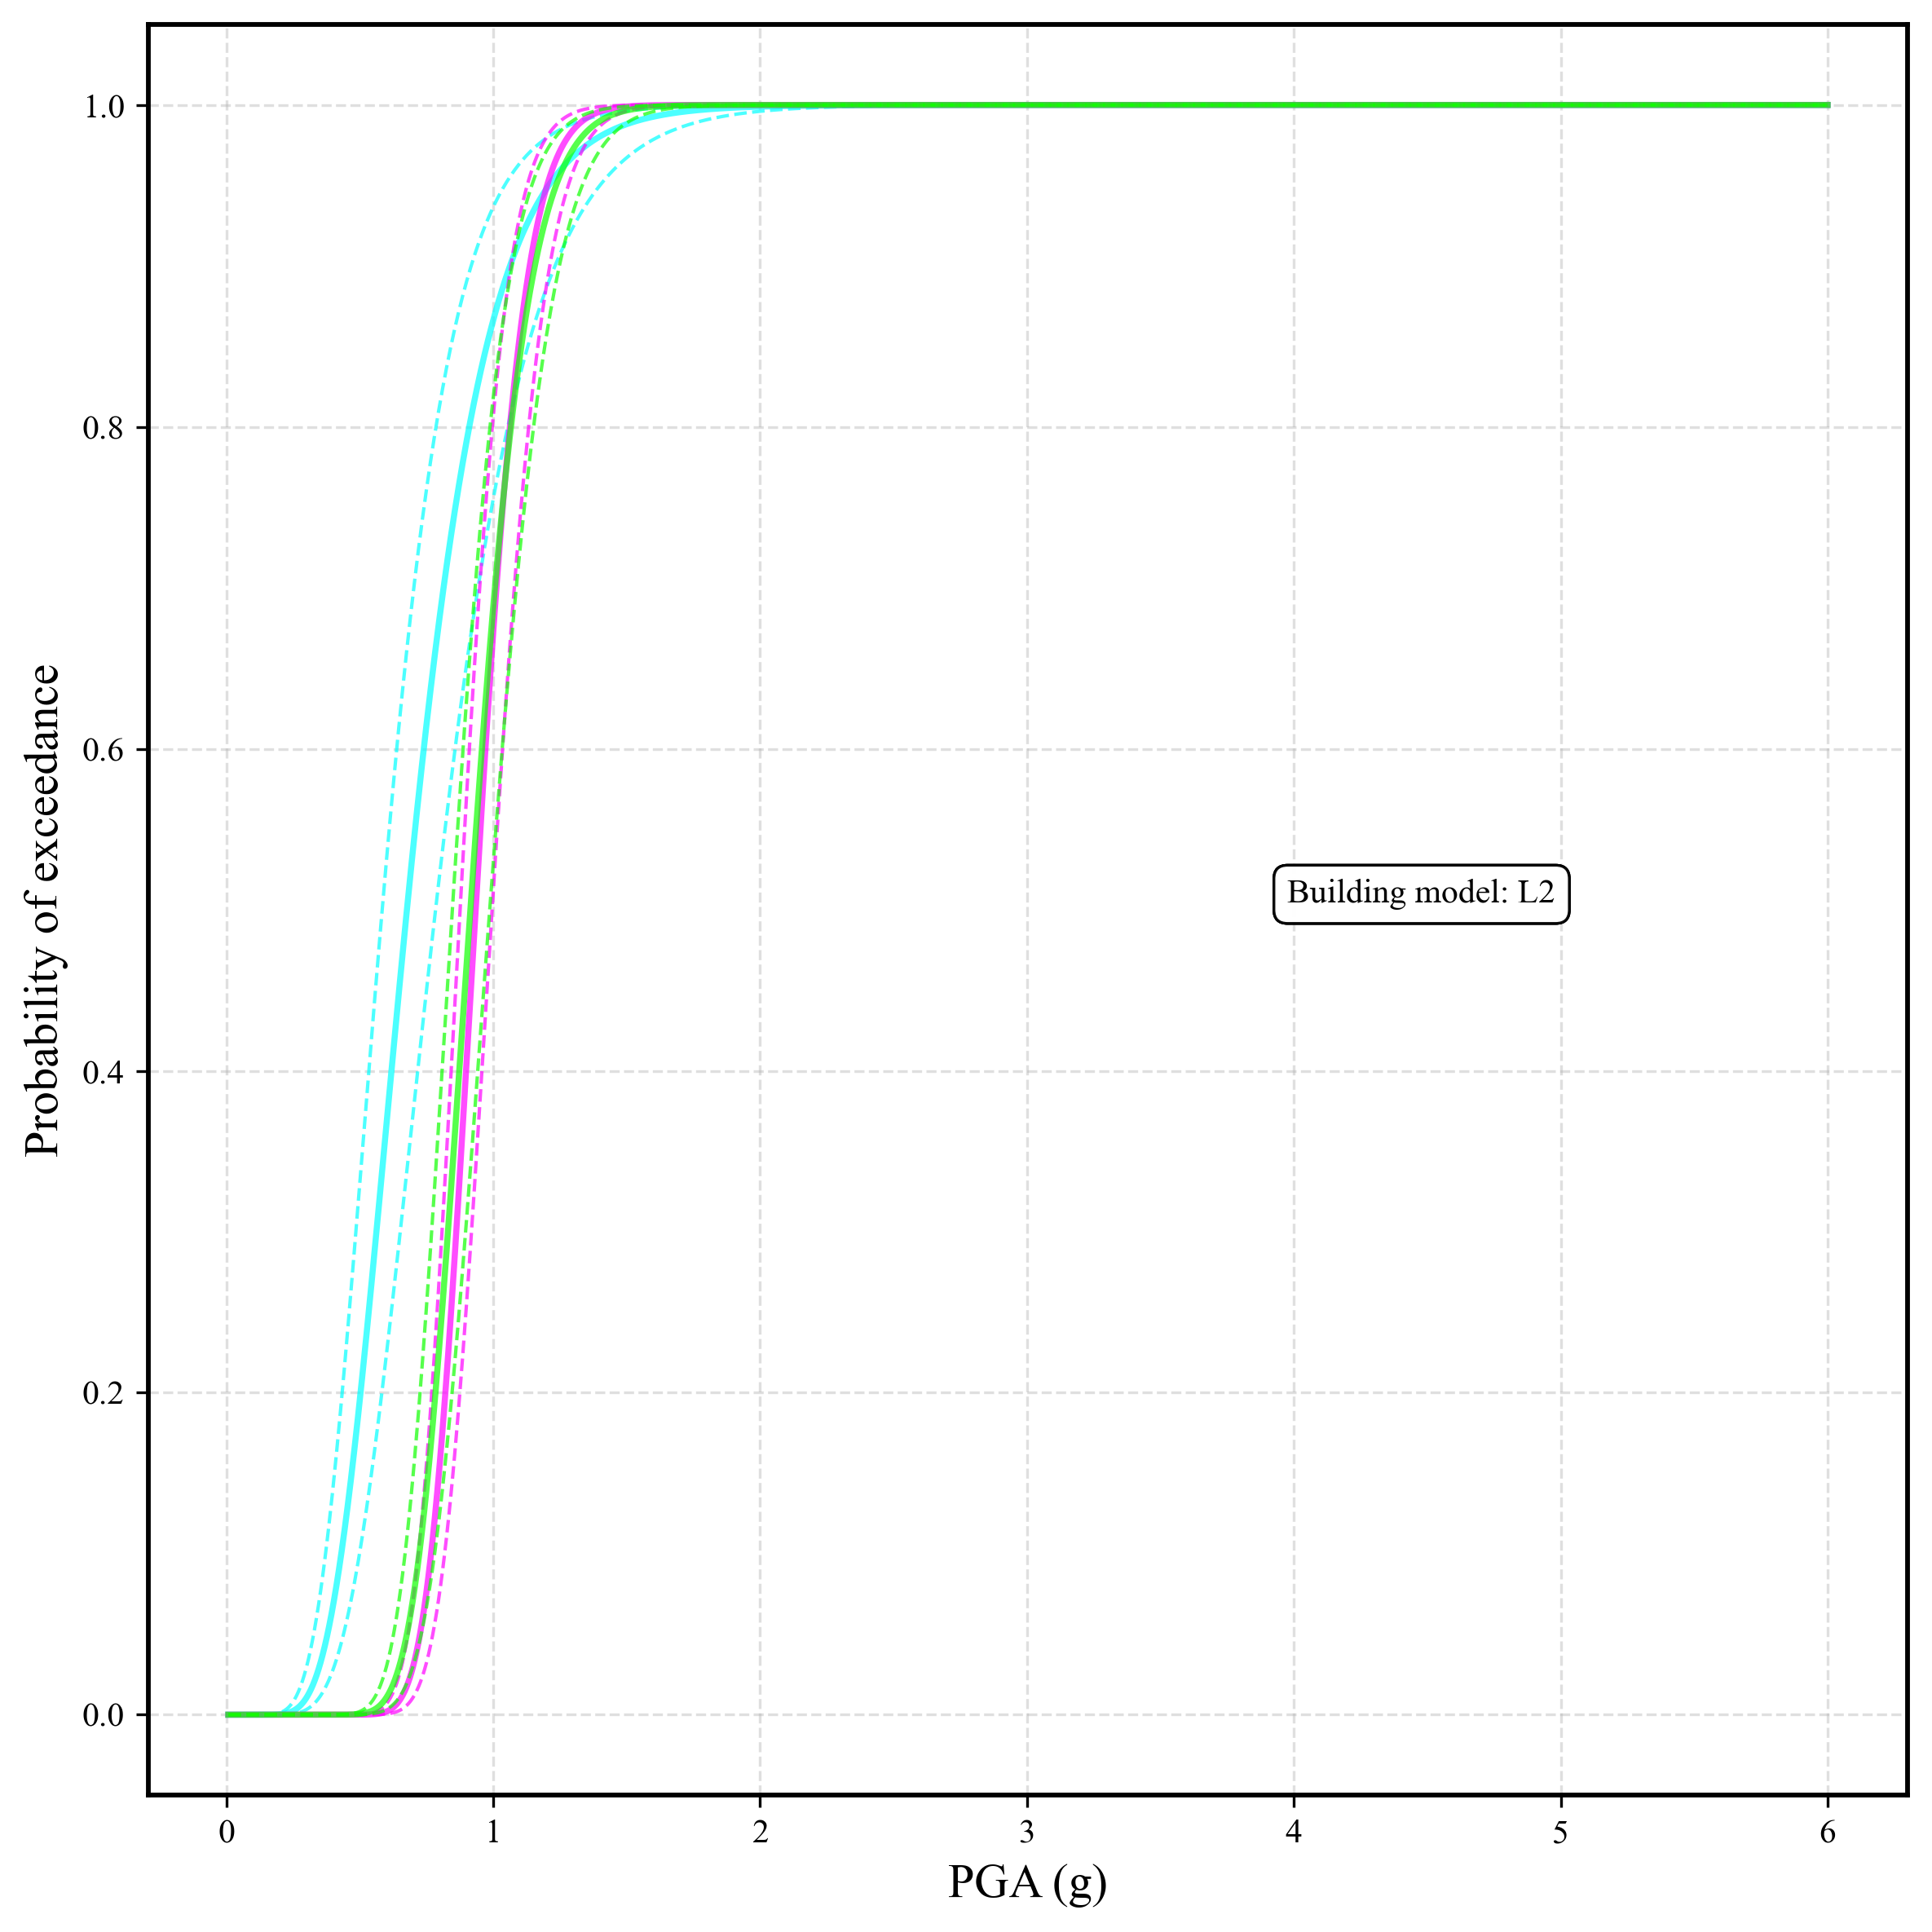

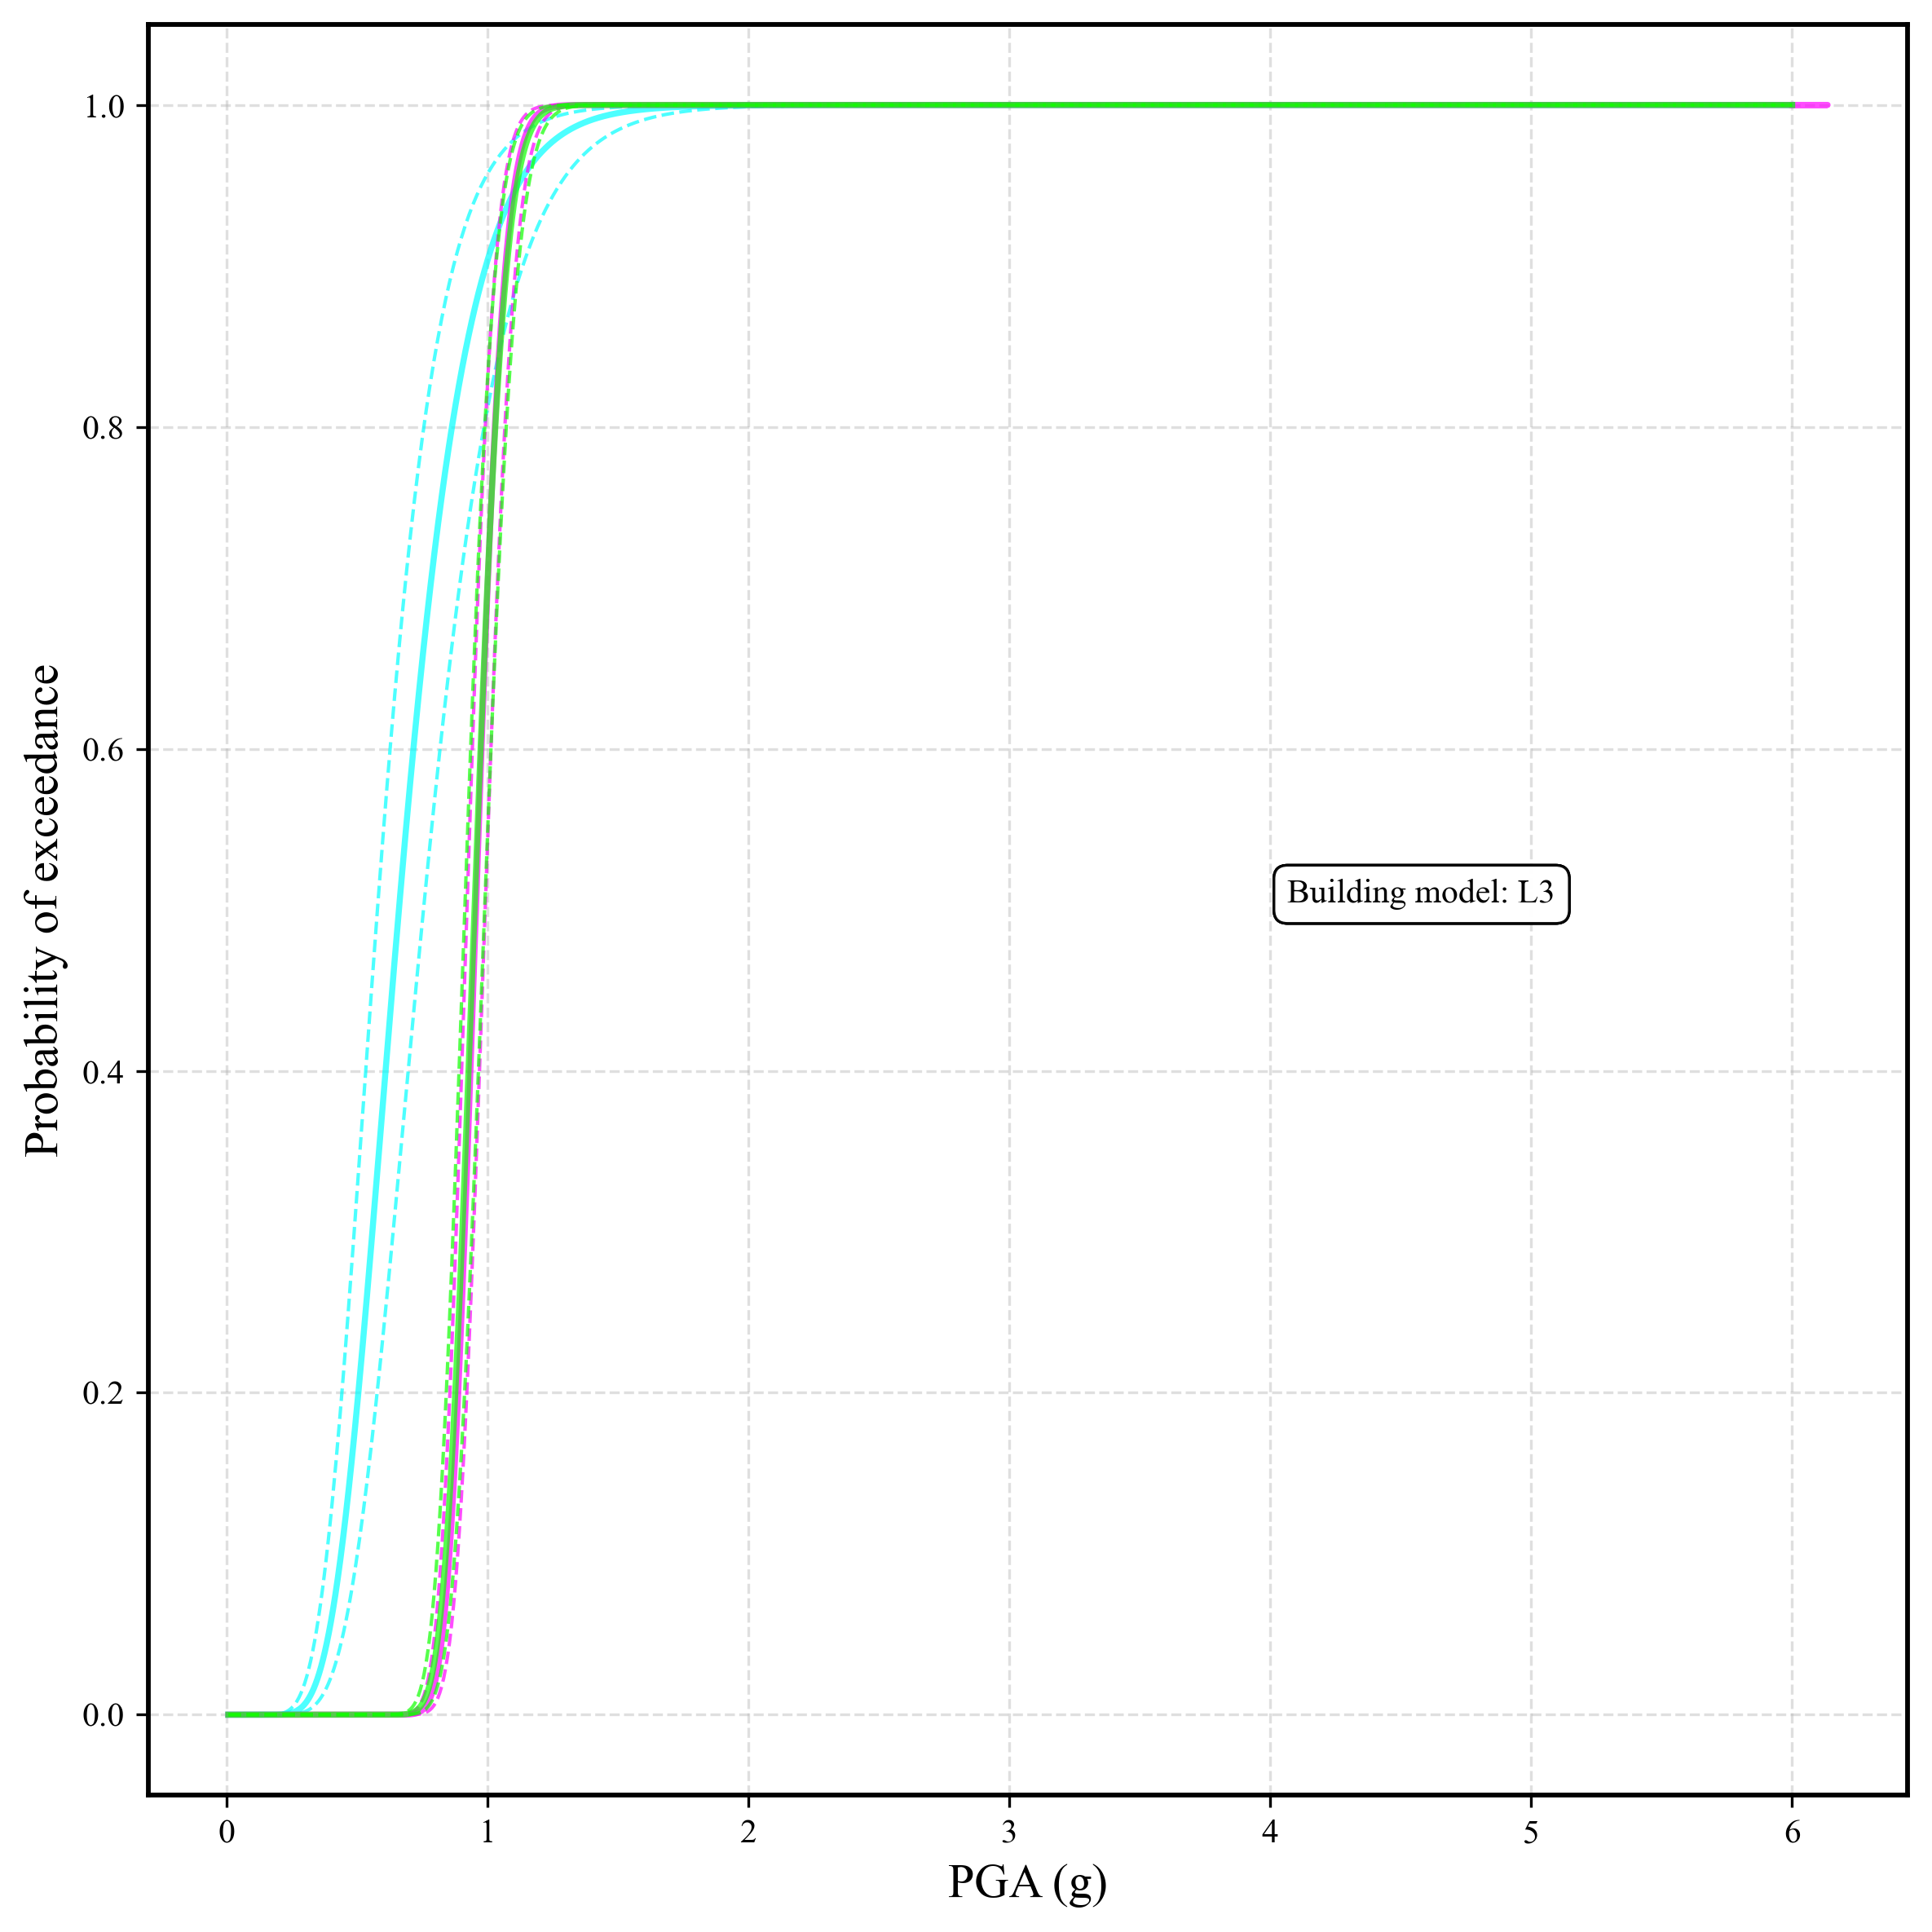

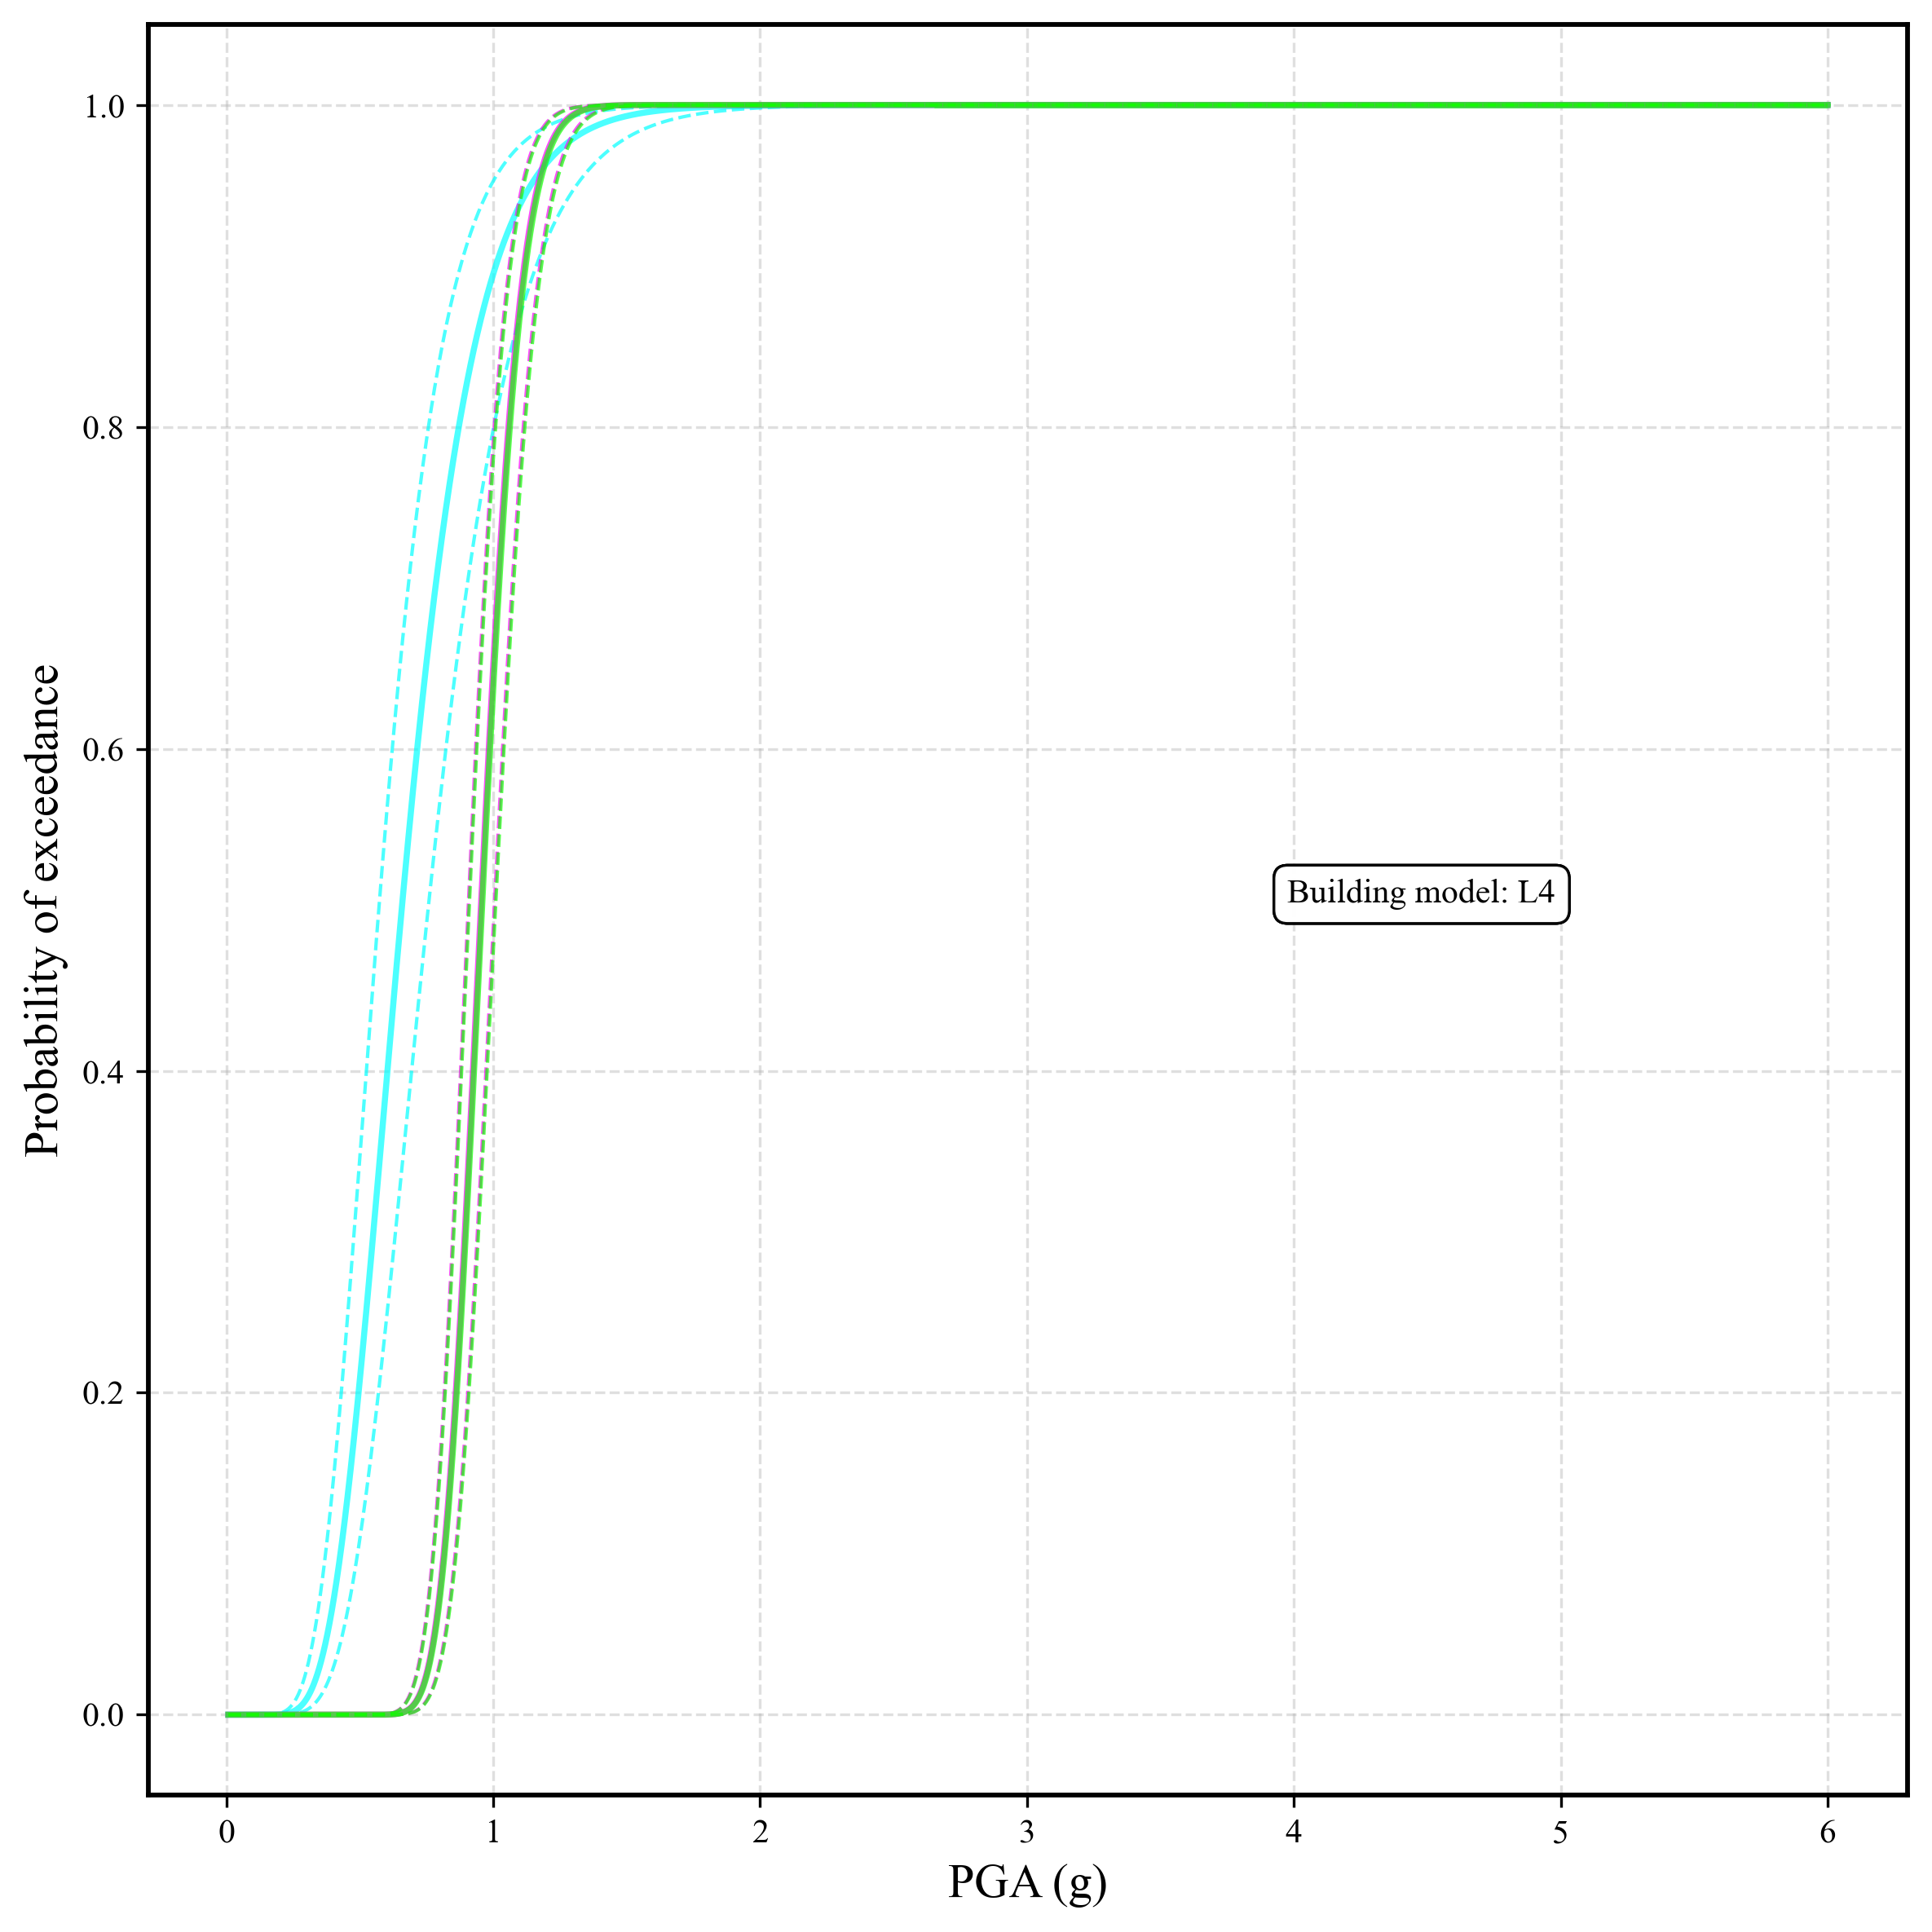

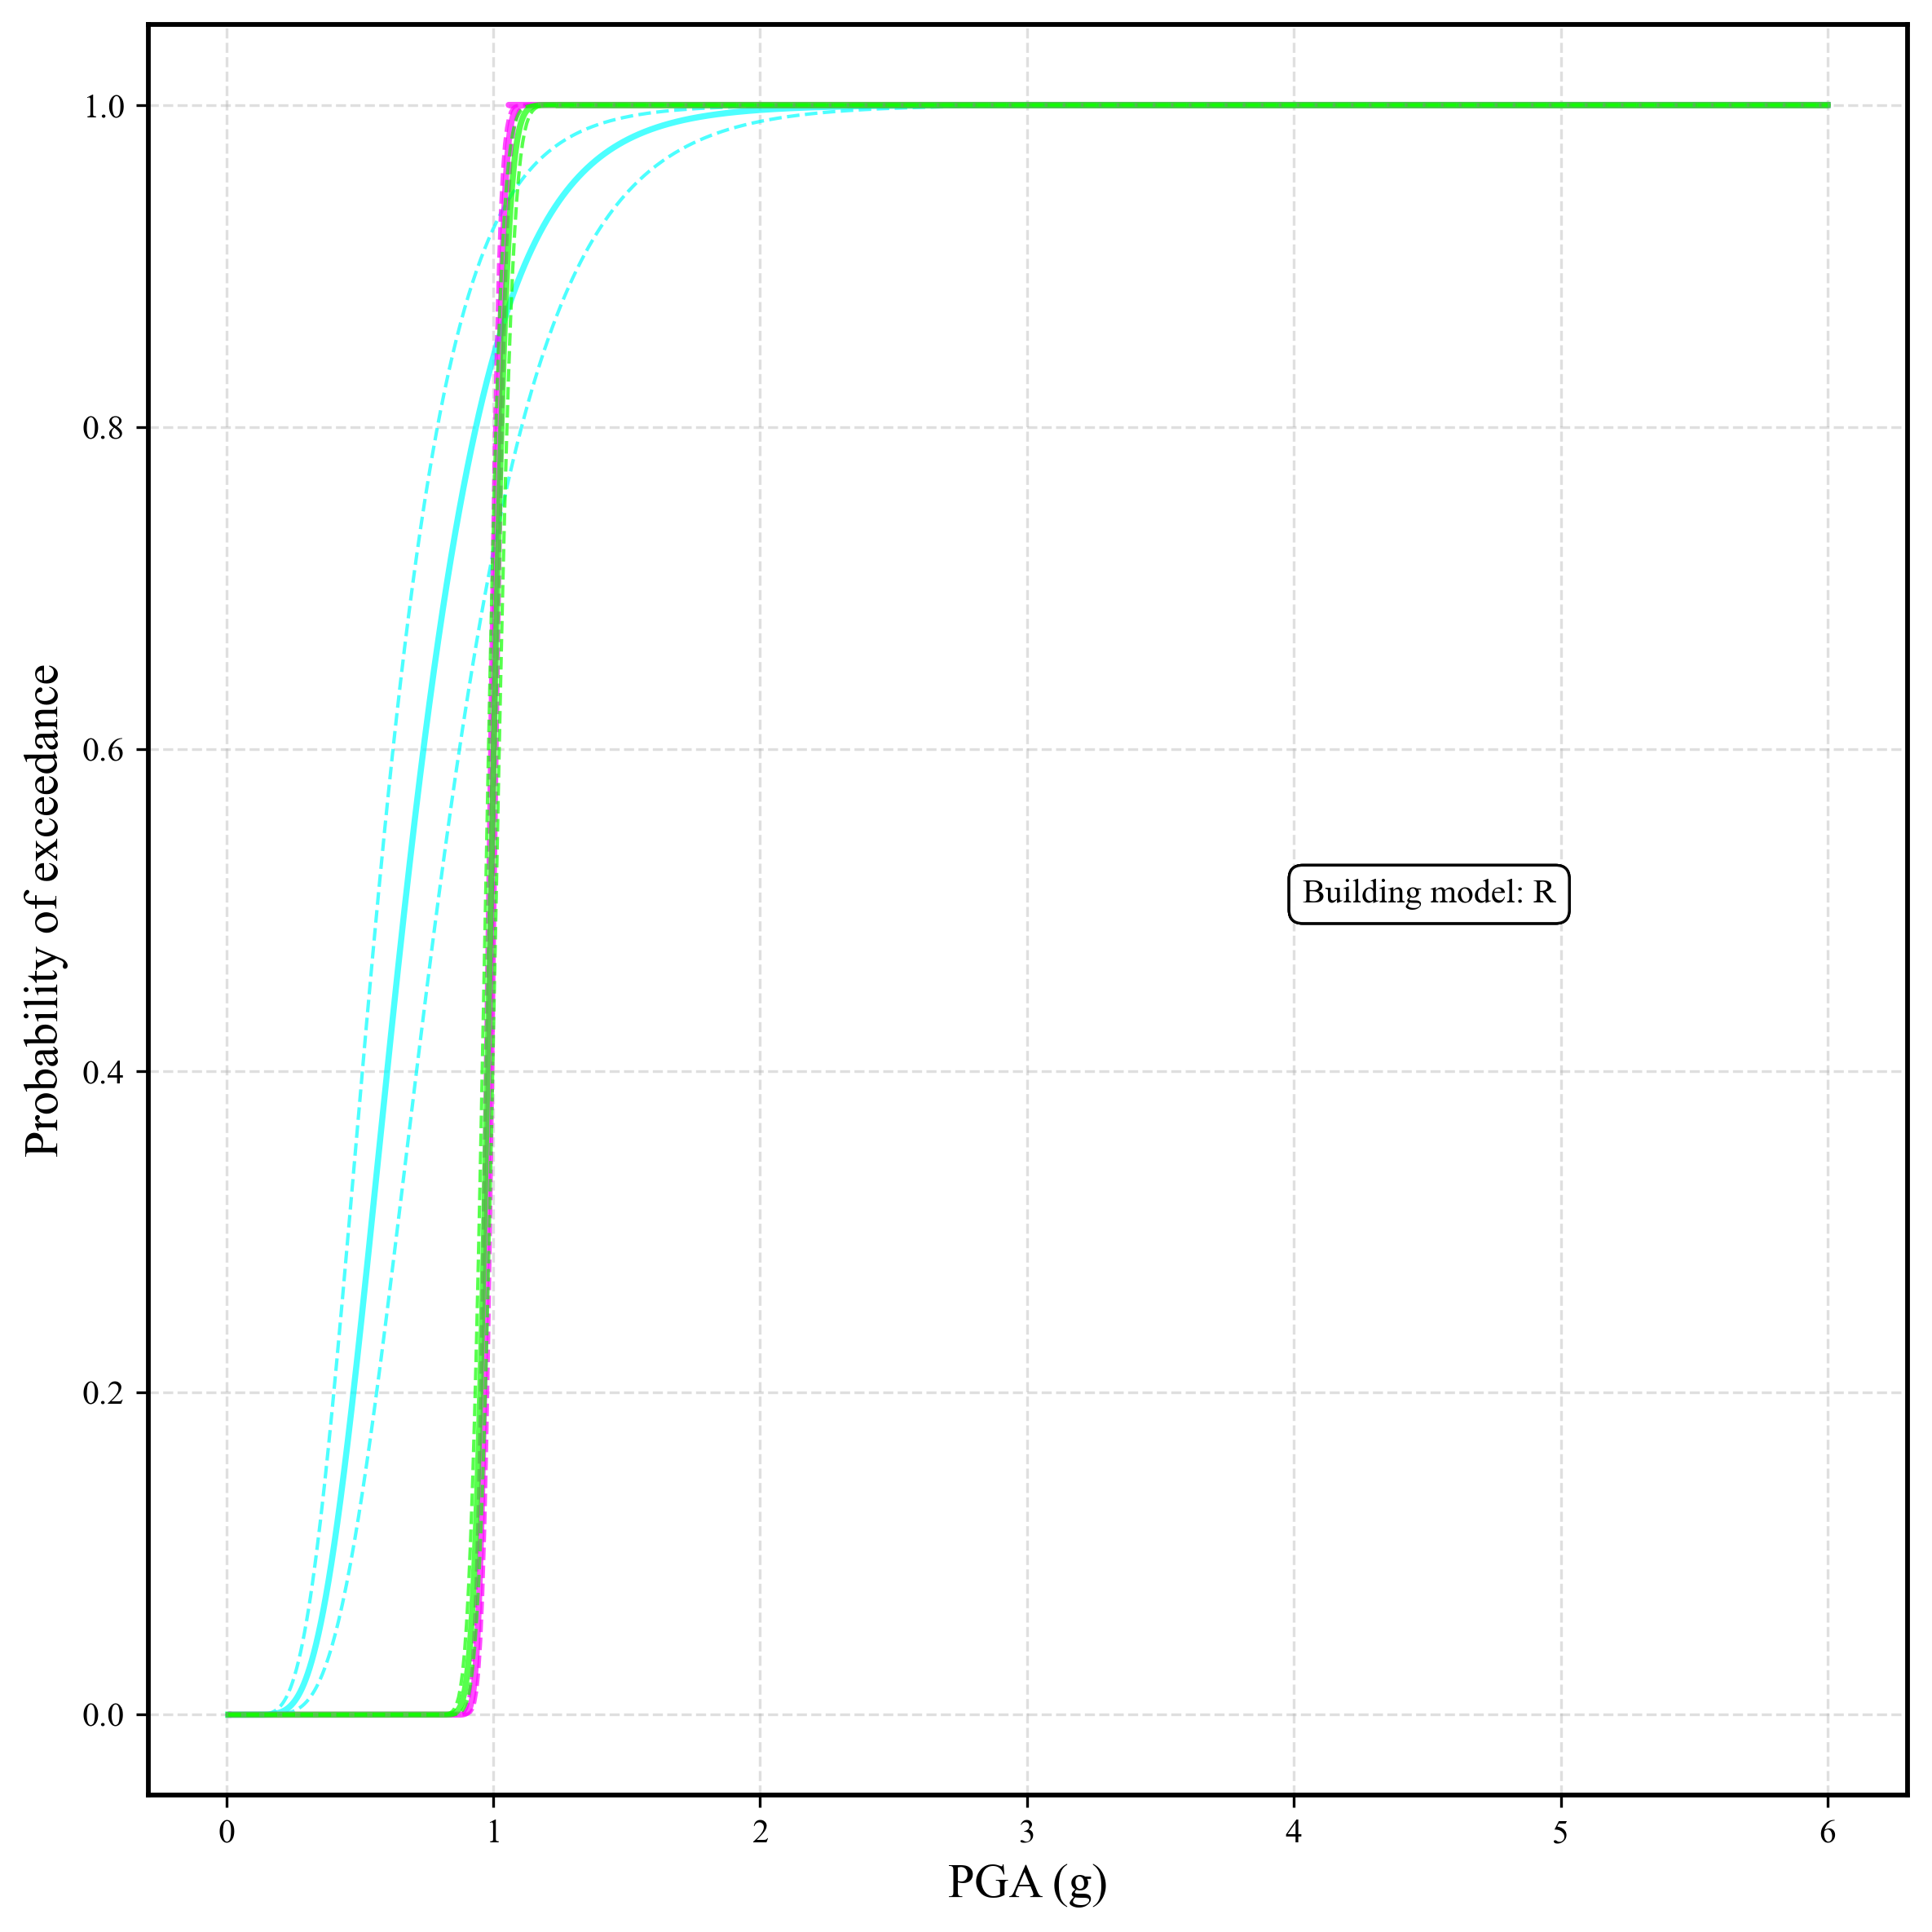

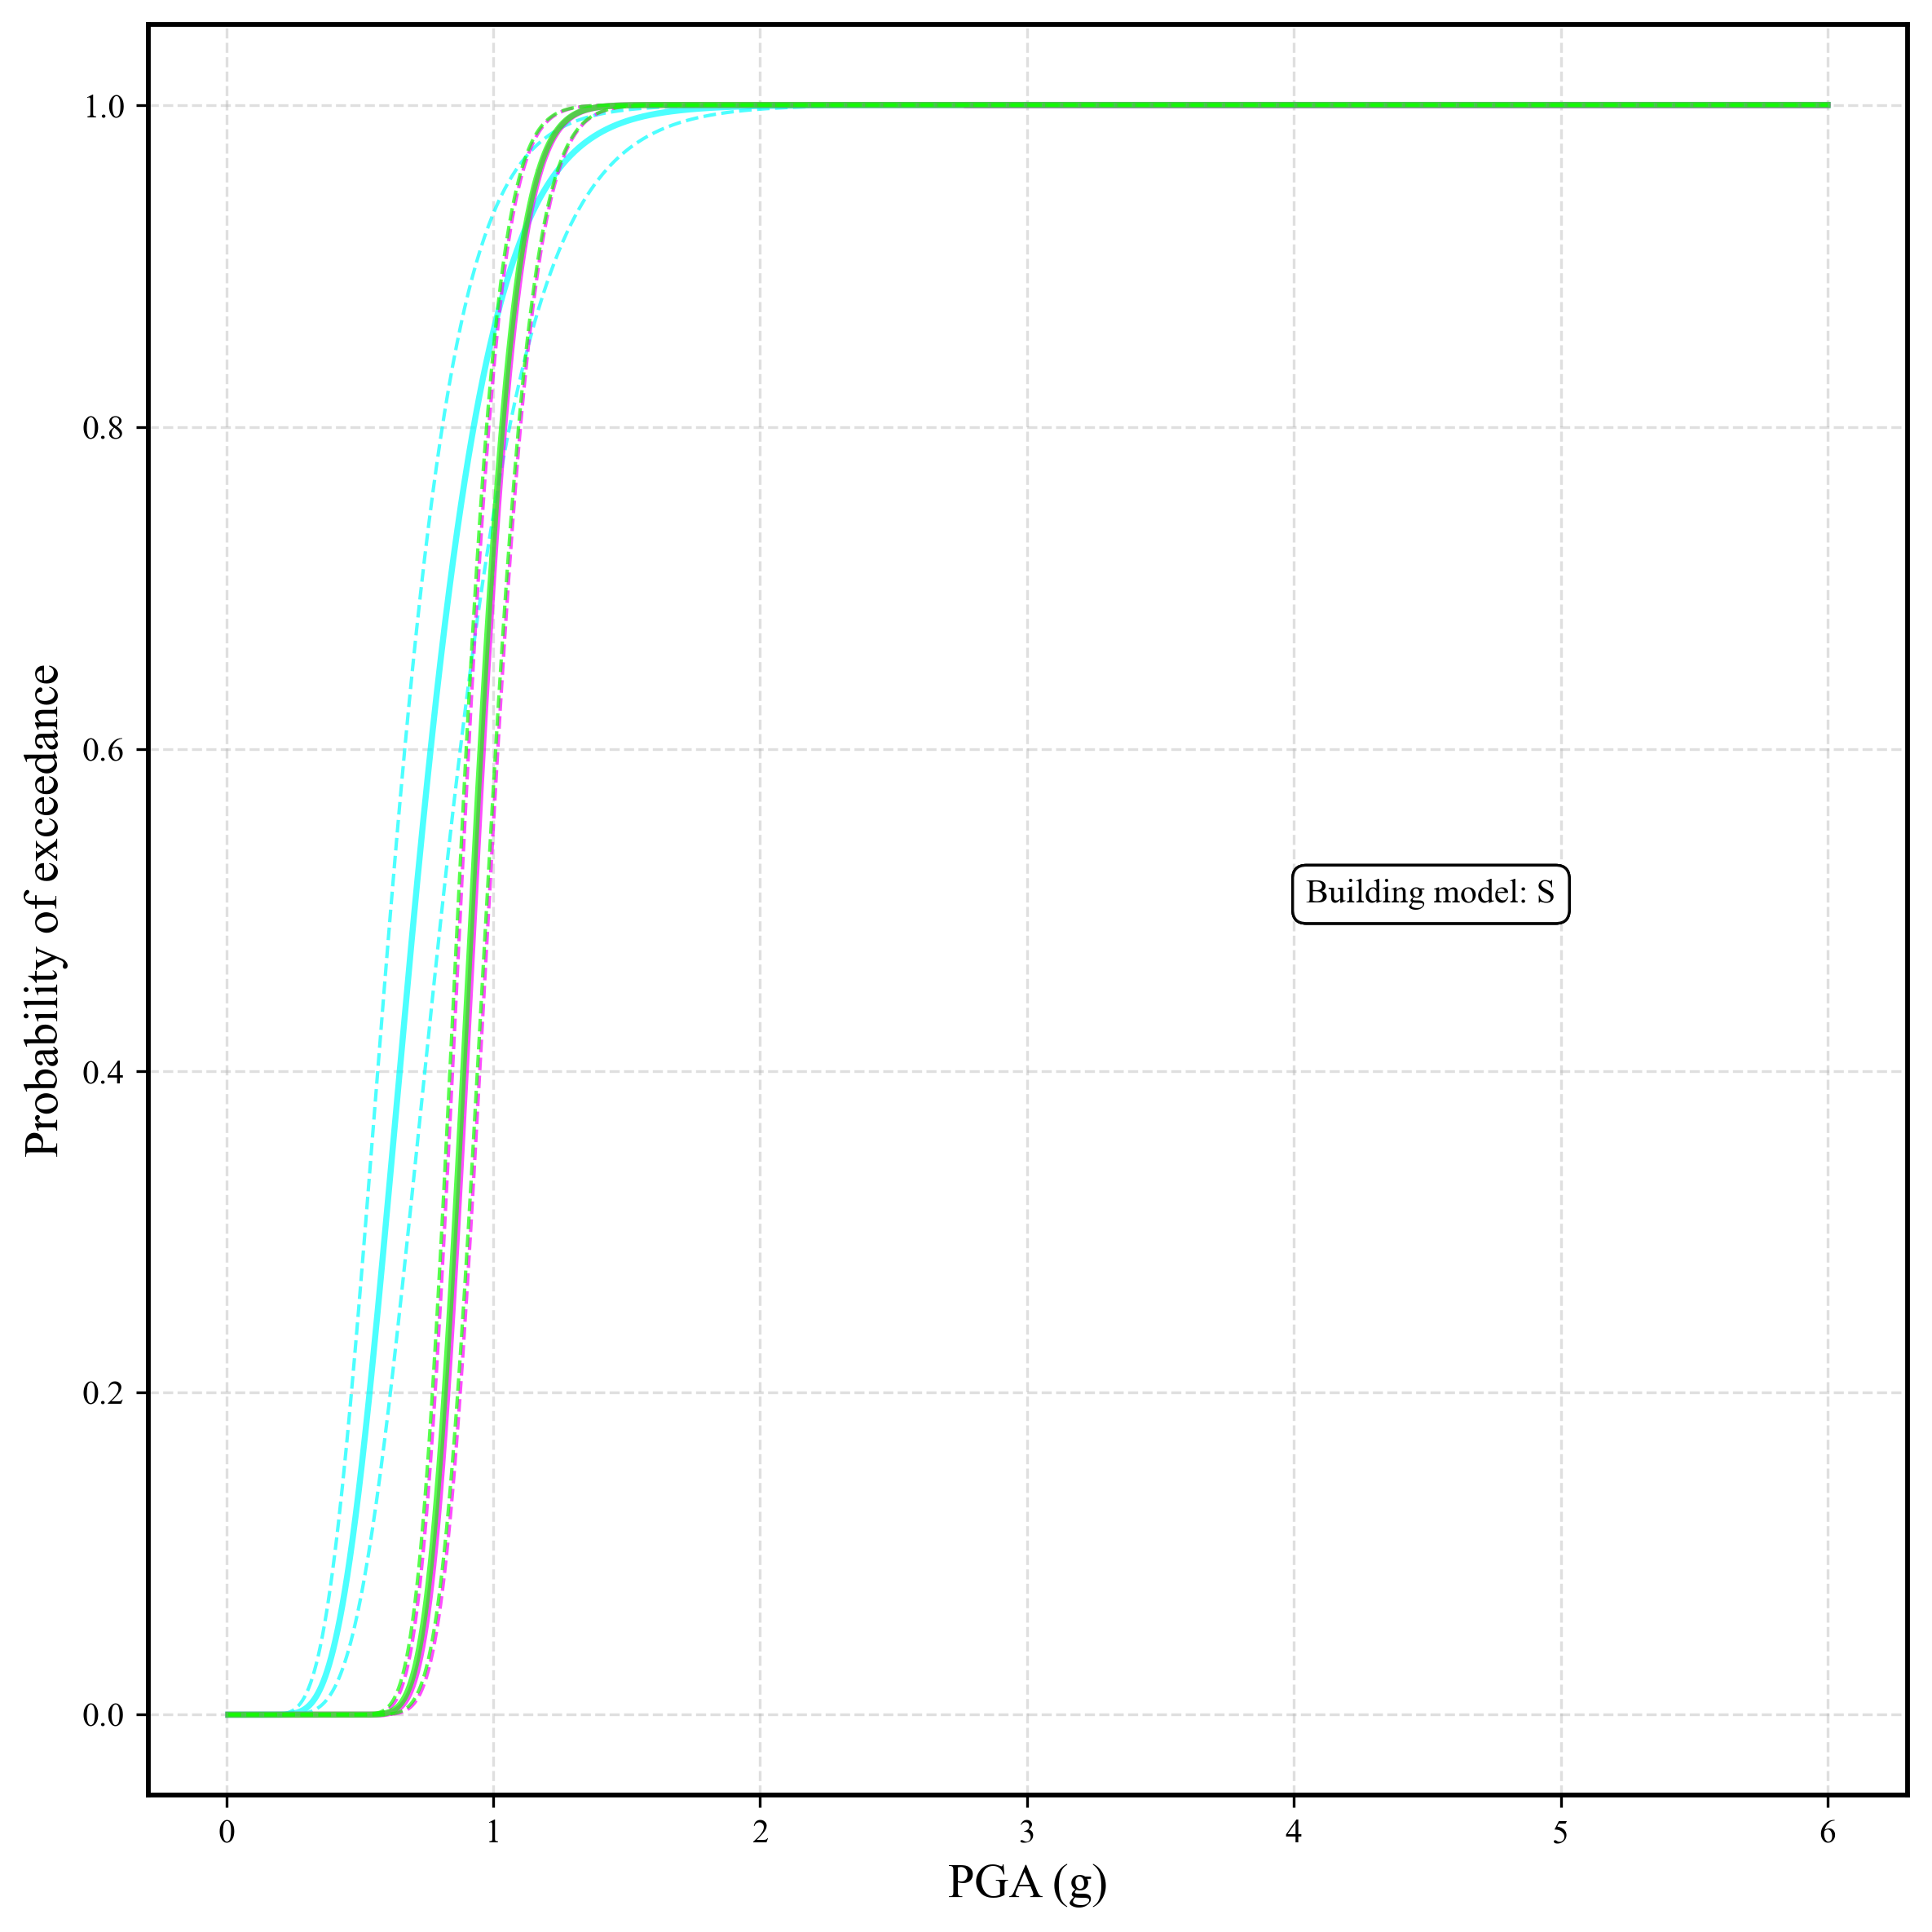

NameError: name 'BuildingSpecificFragilityPlotsWithBounds' is not defined

In [44]:
#Approach for plot production
Damagestates = {"Immediate Occupancy": [0.01, 3], "Life Safety": [0.02, 4.5], "Collapse Prevention": [0.04, 5.5]}
# Damagestates = {"Immediate Occupancy": [0.01, 2], "Life Safety": [0.02, 1.5], "Collapse Prevention": [0.04, 2]} #Soil 

for IDR in list(Damagestates.keys()):
    y_values_dict = get_y_at_idr(df_numeric, "Max_Drift_X", "ScaleFactor", target_idr=Damagestates[IDR][0] )
    legend_handles, legend_labels = DamageSpecificPlots(y_values_dict, upLimit =Damagestates[IDR][1])
    if IDR == list(Damagestates.keys())[0]:
        SaveLegendOnly(legend_handles, legend_labels)


#Next approach for plot production
legend_handles, legend_labels = BuildingSpecificFragilityPlots(df_numeric, "Max_Drift_X", "ScaleFactor", Damagestates, smooth=True, boundshatch=False, boundsLine = True)
SaveLegendOnly(legend_handles, legend_labels)
